In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import glob
import os
import pickle
import random
import sys

import dill
import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

import extq
import prettypyplot as pplt

In [4]:
from joblib import Memory

In [5]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [6]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [7]:
plt.style.use("custom")  # custom style sheet
plt.style.use("vibrant")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [8]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

In [9]:
def get_traj_ids(base_dir):
    ids = []
    k = 0
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            if len(glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.up")) > 0:
                ids.append(k)
            k += 1
    return np.array(ids)


def get_weights(weights, N, k, ids):
    sampled_w = np.concatenate(weights[:, -N::k])
    # set weight for cis/trans to be the same
    sampled_w = np.repeat(sampled_w, 2)
    return sampled_w[ids]


def load_cv(basename):
    arrays = []
    for file in sorted(glob.glob(f"{basename}_??.npy")):
        arrays.append(np.load(file))
    return np.concatenate(arrays)


def load_all(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    data_dir = f"{base_dir}/data"
    weights = np.load(f"{data_dir}/mbar_weights.npy")
    ids = get_traj_ids(base_dir)
    N = 32000
    k = 1000
    sample_w = get_weights(weights, N, k, ids)

    fs_qtots = load_cv(f"{data_dir}/fs_qtots")
    q_gs_all = load_cv(f"{data_dir}/q_gs_all")
    q_gs = load_cv(f"{data_dir}/q_gs")
    q_fs_all = load_cv(f"{data_dir}/q_fs_all")
    q_fs = load_cv(f"{data_dir}/q_fs")
    q_core = load_cv(f"{data_dir}/q_core")
    omegas = load_cv(f"{data_dir}/omegas")

    c_green = fs_qtots[:, 5] - fs_qtots[:, 4]
    c_blue = fs_qtots[:, 7] - fs_qtots[:, 6]
    c_orange = fs_qtots[:, 3] - fs_qtots[:, 2]
    c_0 = fs_qtots[:, 1] - fs_qtots[:, 0]
    n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)

    cvs = dict(
        blue=c_blue,
        green=c_green,
        orange=c_orange,
        c0=c_0,
        q_gs_all=q_gs_all,
        q_fs_all=q_fs_all,
        q_gs=q_gs,
        q_fs=q_fs,
        q_core=q_core,
        n_cis=n_cis,
    )
    return cvs, sample_w

In [10]:
home_dir = "/project/dinner/scguo/kaiB"

In [11]:
cvs_all_ts, weights_all_ts = [], []
for t in [87, 89, 91]:
    cvs, weights = load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)

In [12]:
labels = dict(
    blue=r"$\alpha3_{\mathrm{fs}}\longleftrightarrow\beta4_{\mathrm{gs}}$",
    green=r"$\beta4_{\mathrm{fs}}\longleftrightarrow\alpha3_{\mathrm{gs}}$",
    orange=r"$\beta3_{\mathrm{fs}}\longleftrightarrow\alpha2_{\mathrm{gs}}$",
    c0=r"$\alpha2_{\mathrm{fs}}\longleftrightarrow\beta3_{\mathrm{gs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C-term}}$",
    q_fs=r"$Q_{\mathrm{fs, C-term}}$",
    q_core=r"$Q_{\mathrm{N-term}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
)
lims = dict(
    blue=(-1, 1.3),
    green=(-1.3, 1),
    orange=(-1.3, 1),
    c0=(-1, 1.3),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
)

In [13]:
qp_all_ts = []
for t in [87, 89, 91]:
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp_all_ts.append(dill.load(f))

In [14]:
lags = np.array([50, 100, 200], dtype=int)
mems = np.array([1, 4, 9], dtype=int)

In [15]:
def plot_qp(qp, sample_w, cvs, cv1="green", cv2="blue"):
    fig, axes = plt.subplots(
        nrows=3, ncols=3, figsize=(7, 7.5), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )
    xe = np.linspace(*lims[cv1], 51)
    ye = np.linspace(*lims[cv2], 51)
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    for i in range(3):
        lag = lags[i]
        for j in range(3):
            mem = mems[j]
            ax = axes[i, j]
            q = np.asarray(qp[(lag, mem)])[..., :-lag]
            hist = extq.projection.average2d(
                cvs[cv1][..., :-lag],
                cvs[cv2][..., :-lag],
                q,
                np.broadcast_to(sample_w[..., None], q.shape),
                xe,
                ye,
            )
            pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
            ax.set_xlabel(labels[cv1])
            ax.set_ylabel(labels[cv2])
            ax.set_title(f"$\\tau = {lag}$, $\\tau/\\sigma = {mem + 1}$")
            ax.label_outer()
    cb = plt.colorbar(pc, ax=axes[0], location="top", label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


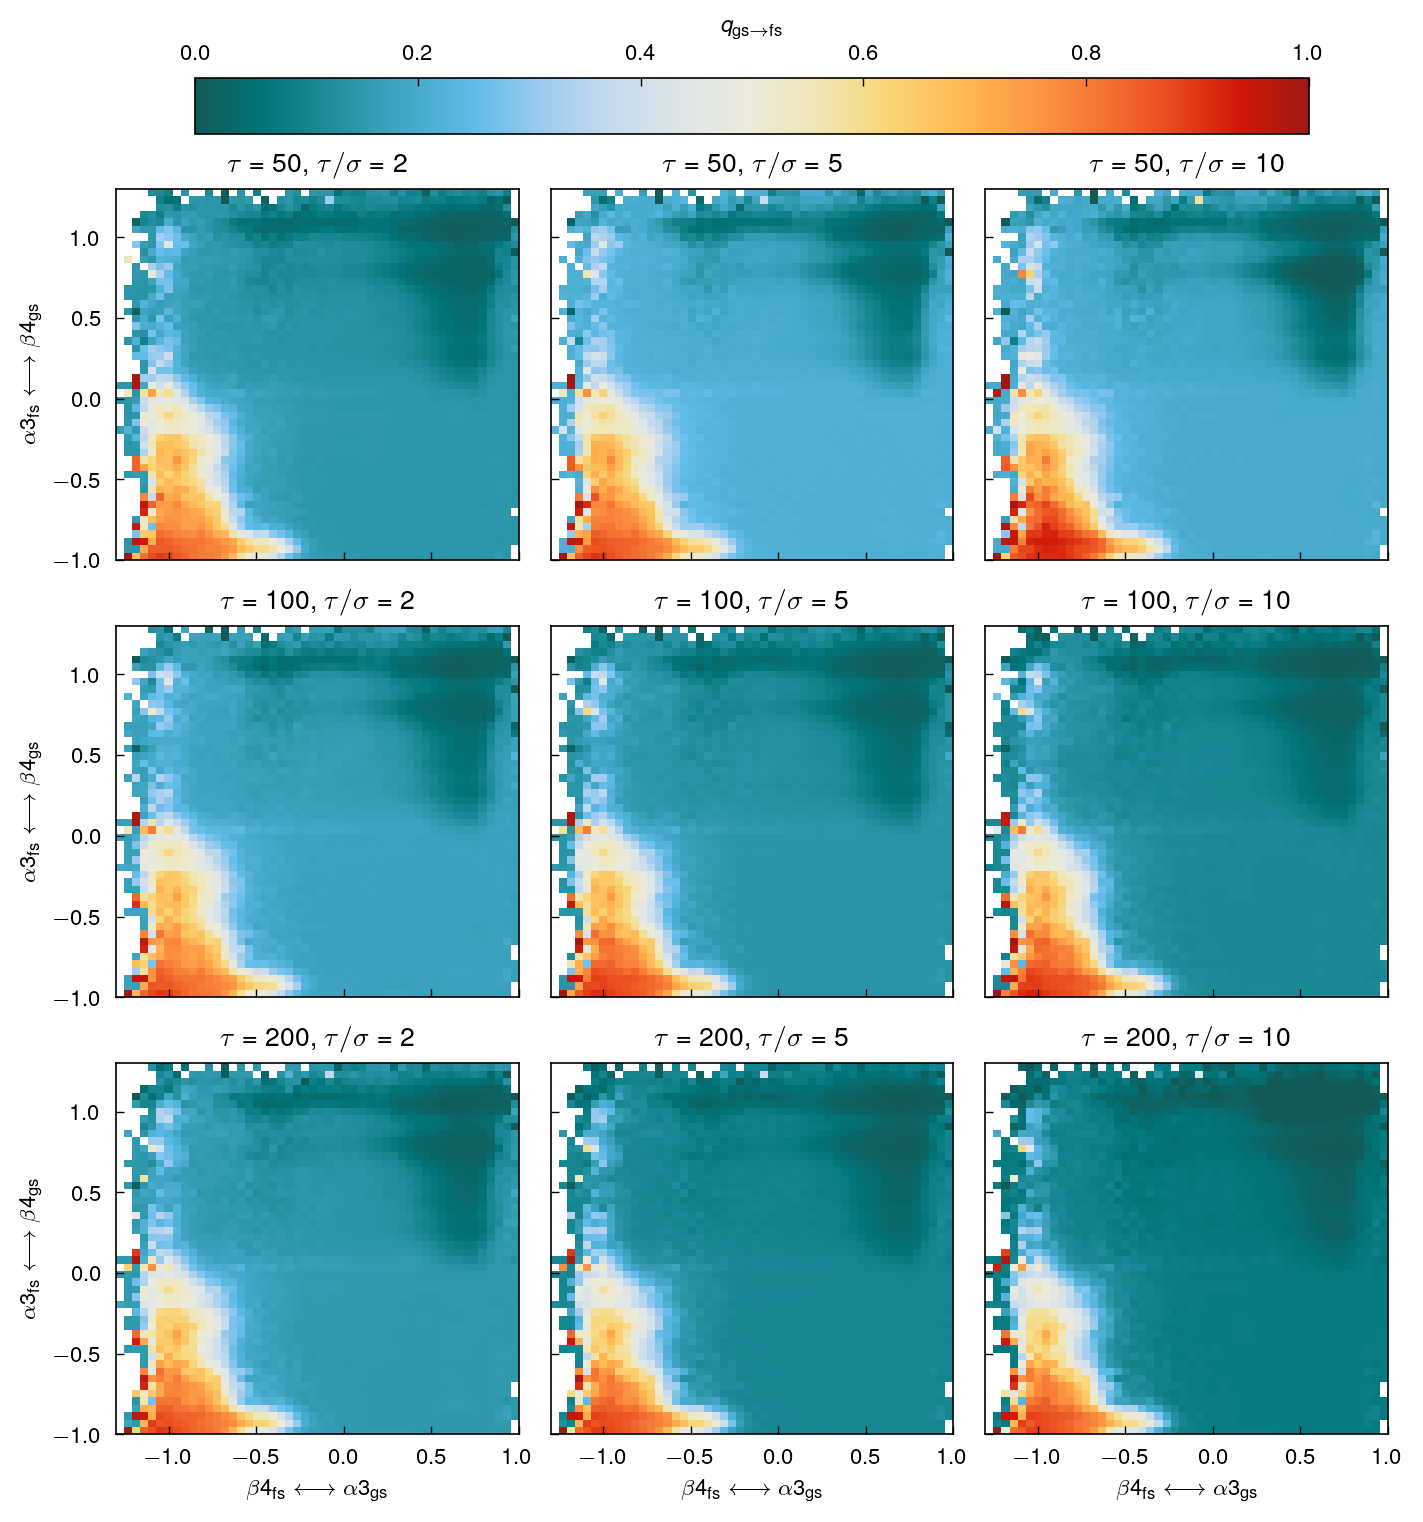

In [16]:
# plot against "GT" and "BT"
plot_qp(qp_all_ts[0], weights_all_ts[0], cvs_all_ts[0])

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


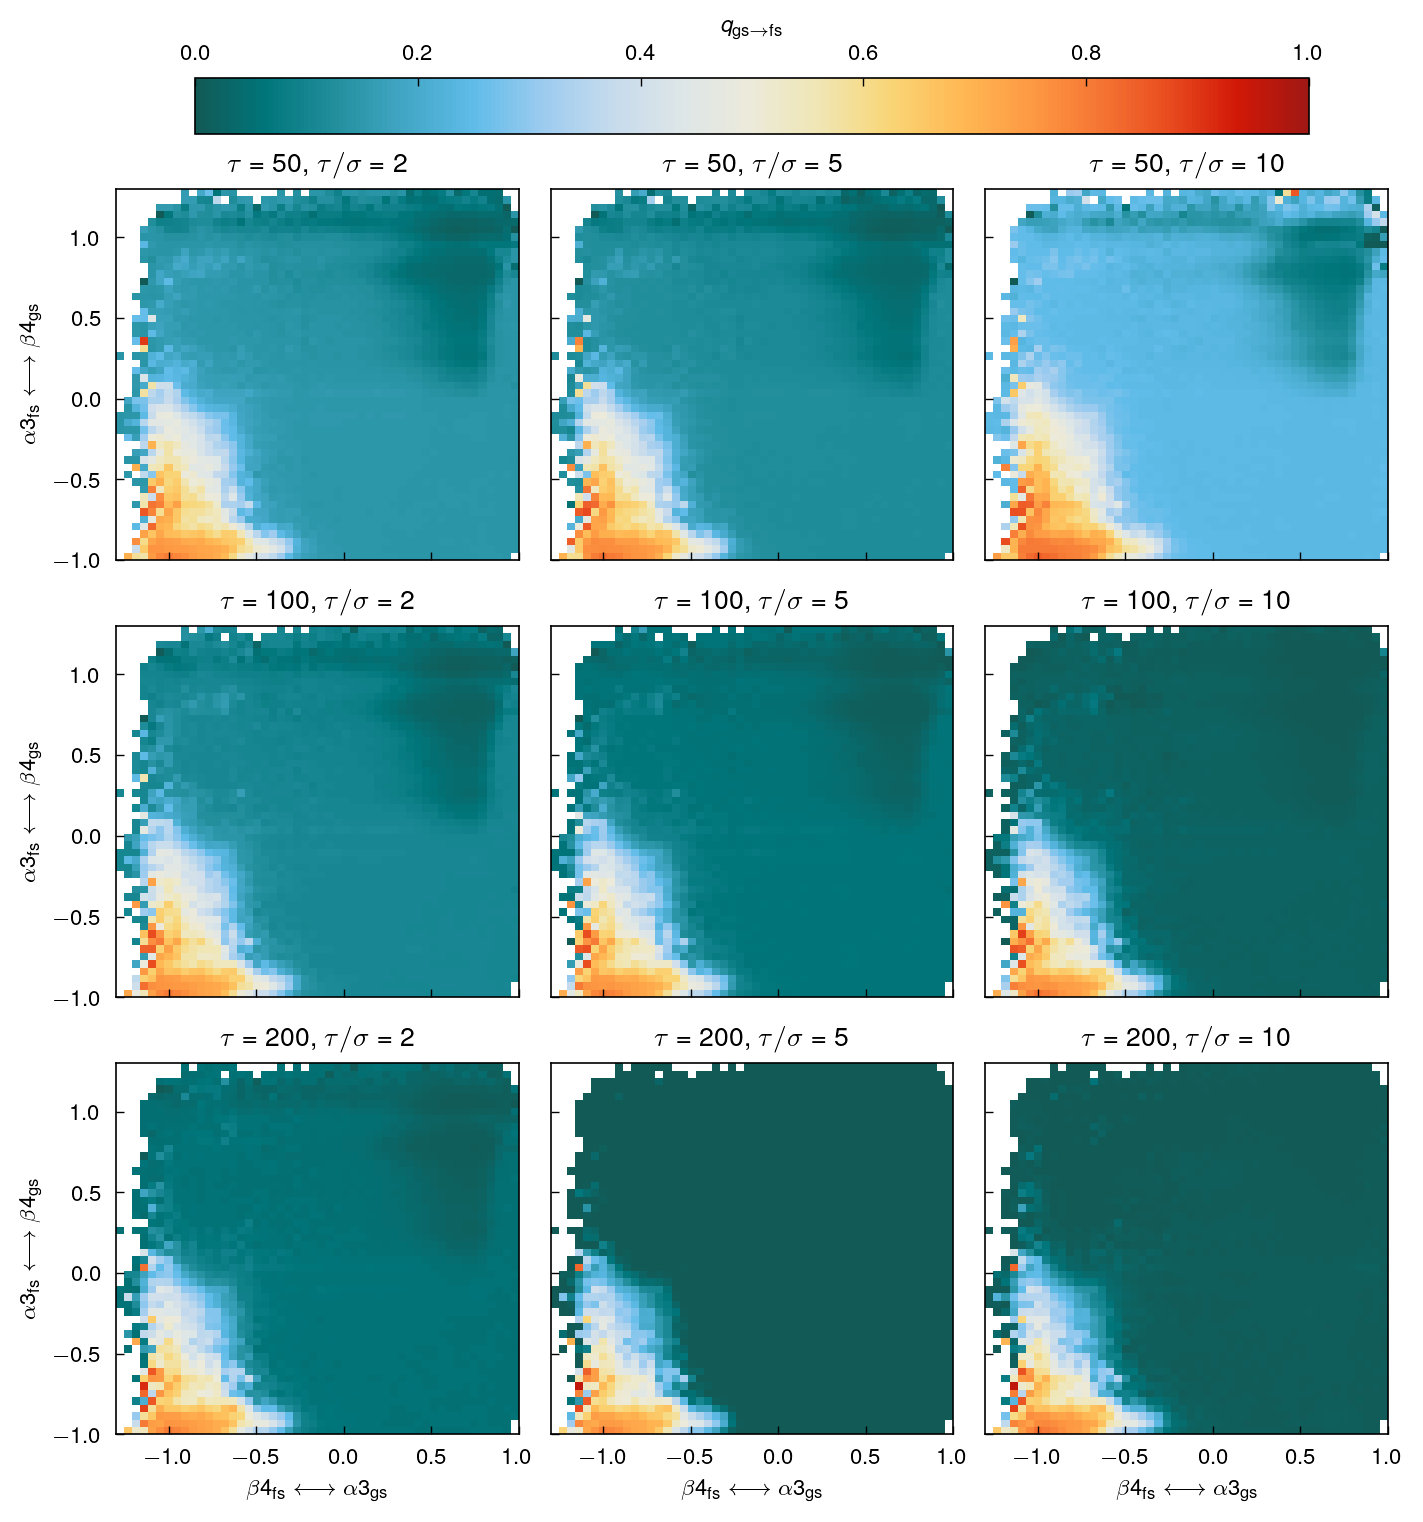

In [17]:
# plot against "GT" and "BT"
plot_qp(qp_all_ts[1], weights_all_ts[1], cvs_all_ts[1])

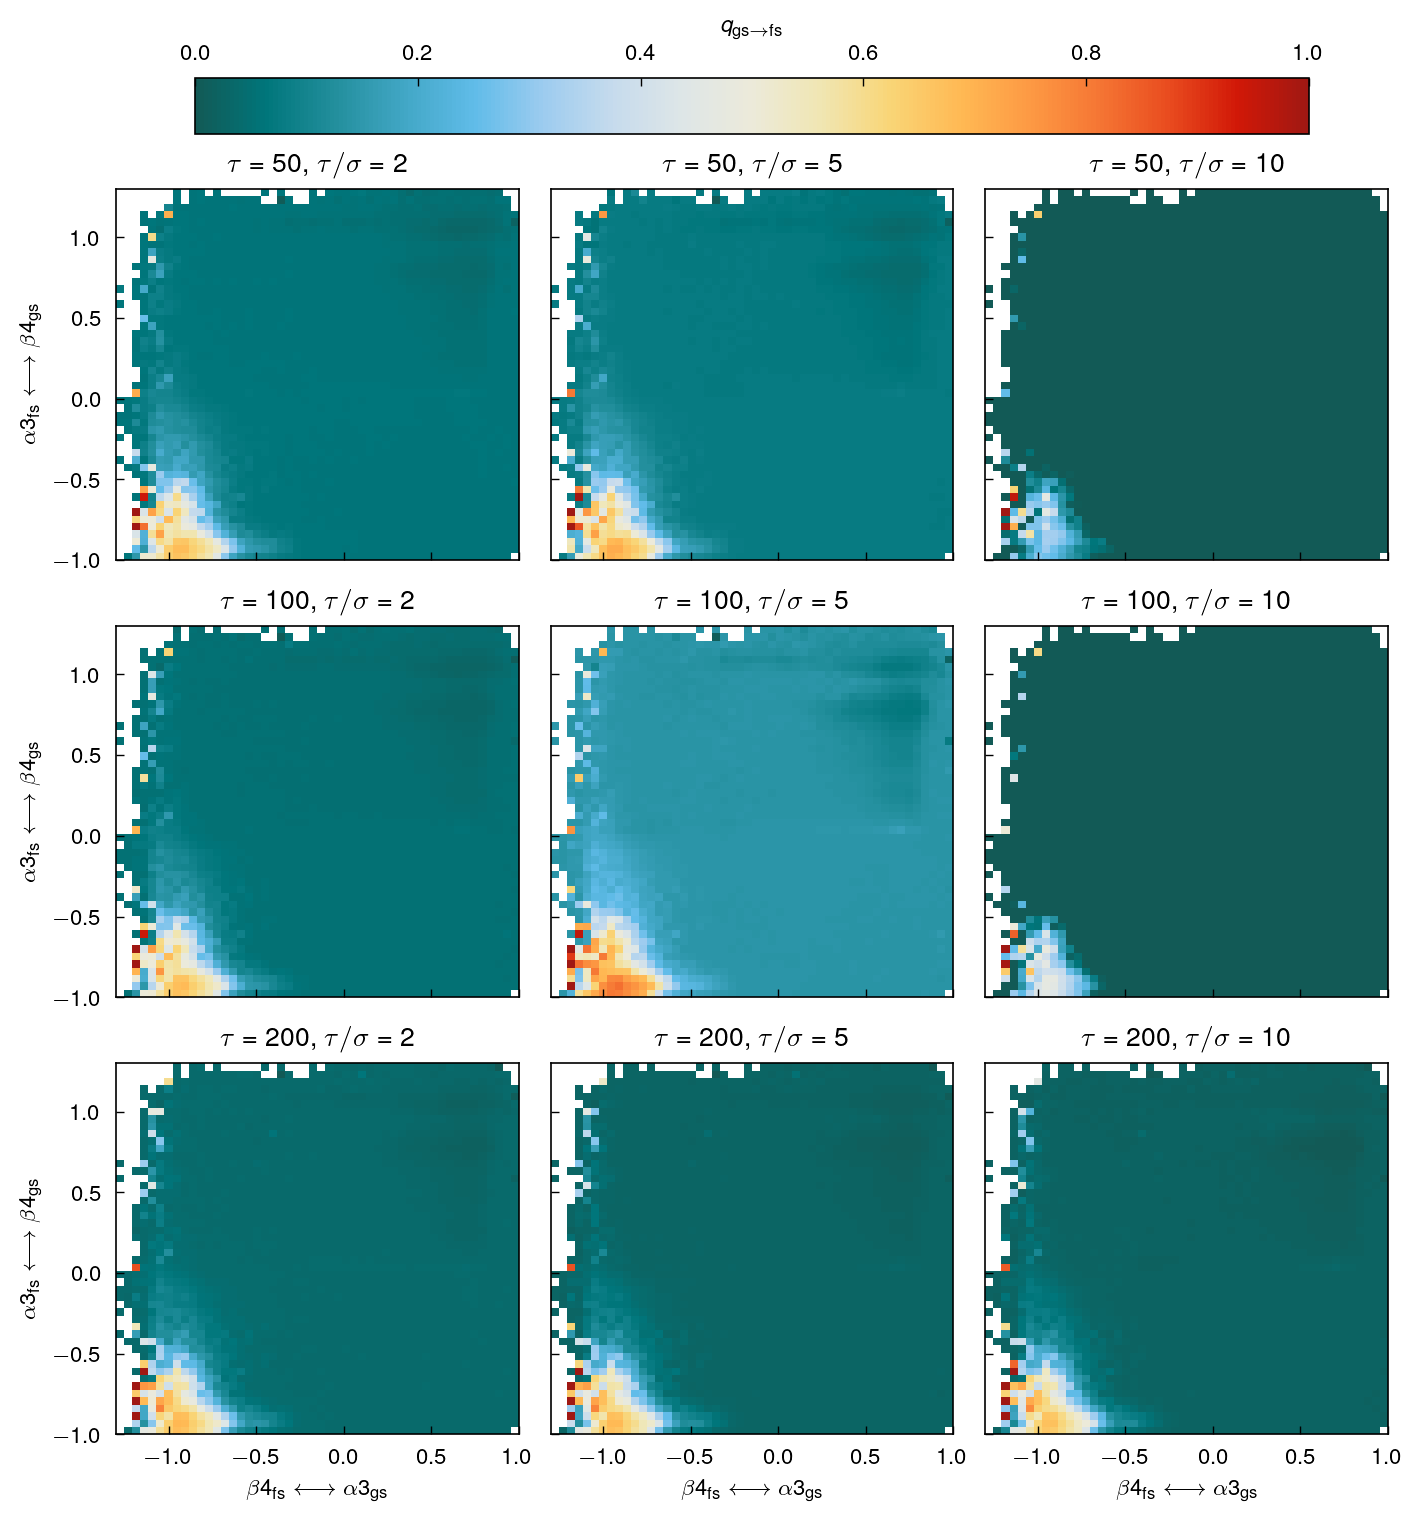

In [18]:
# plot against "GT" and "BT"
plot_qp(qp_all_ts[2], weights_all_ts[2], cvs_all_ts[2])

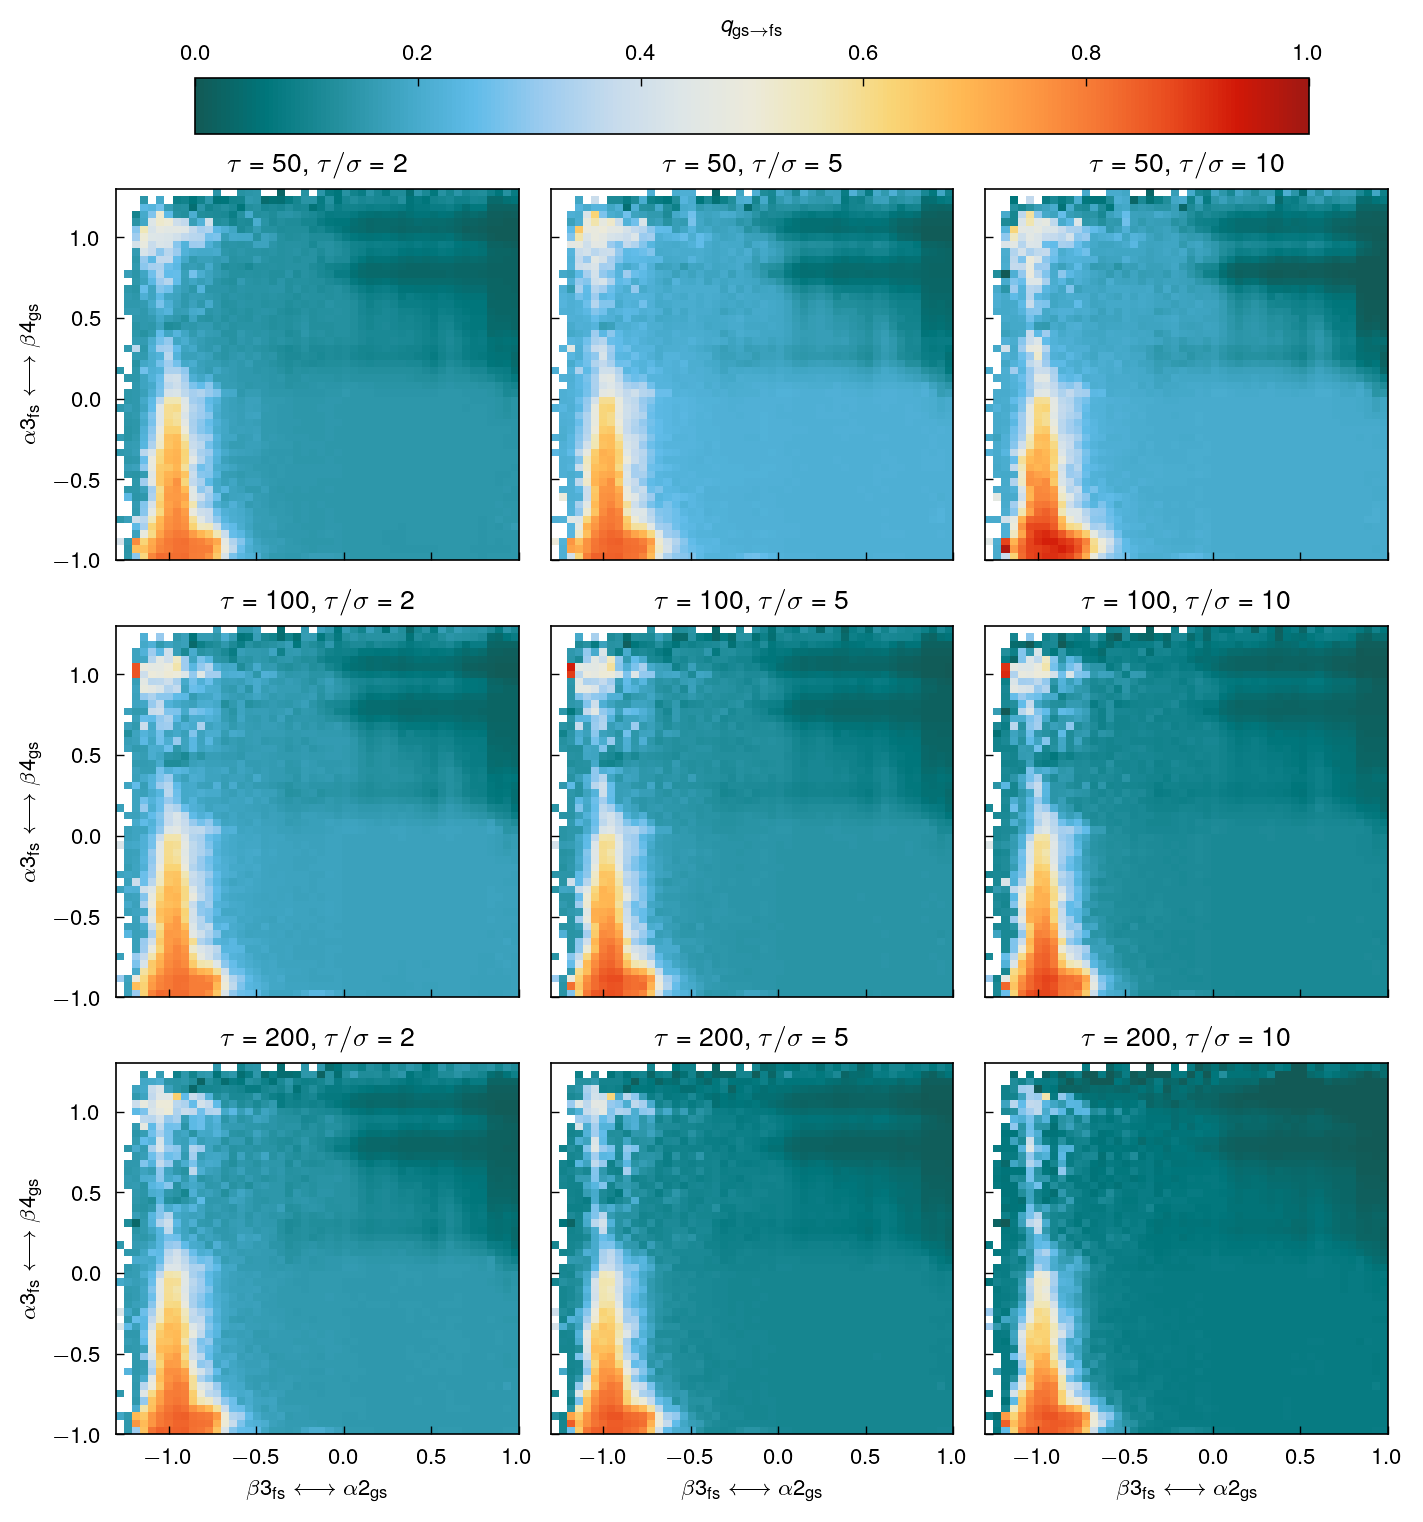

In [19]:
# plot against "OT" and "BT"
plot_qp(qp_all_ts[0], weights_all_ts[0], cvs_all_ts[0], cv1="orange", cv2="blue")

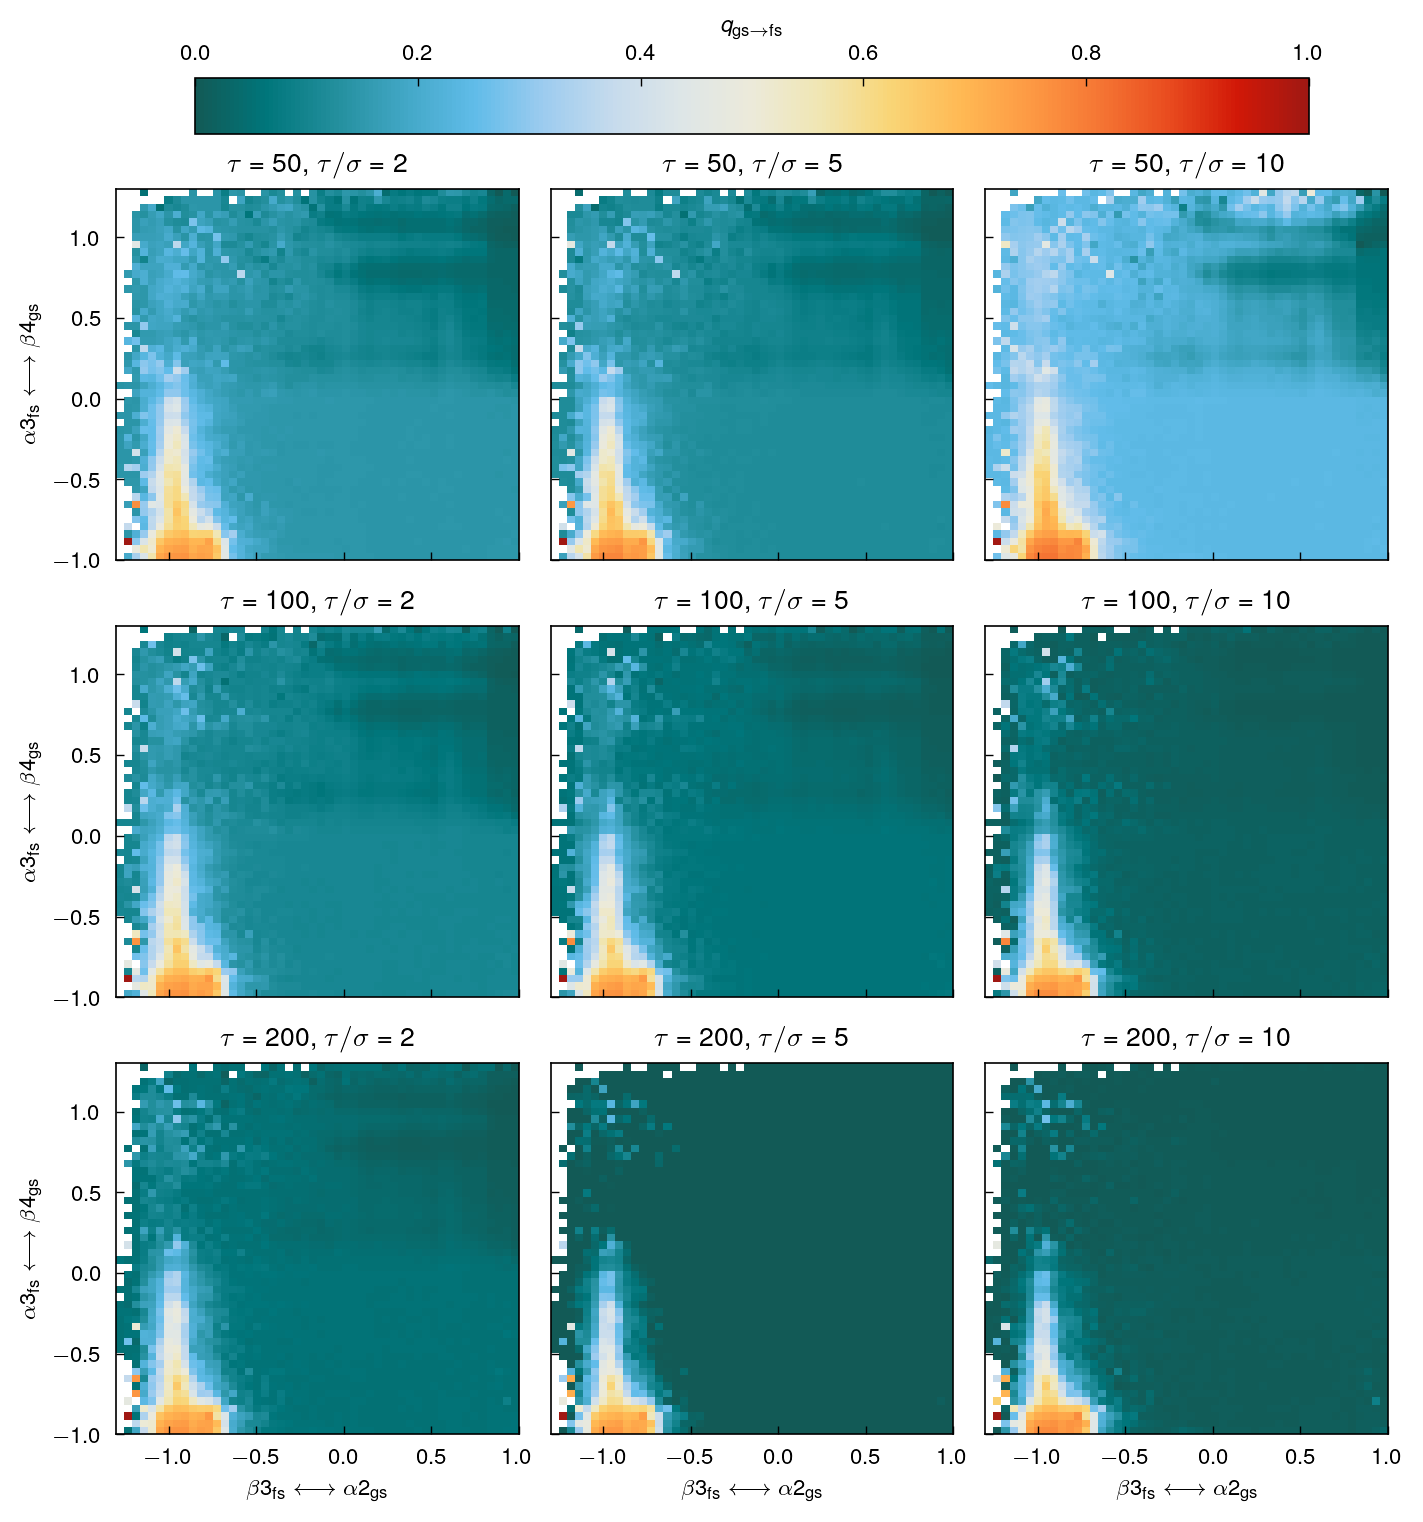

In [20]:
plot_qp(qp_all_ts[1], weights_all_ts[1], cvs_all_ts[1], cv1="orange", cv2="blue")

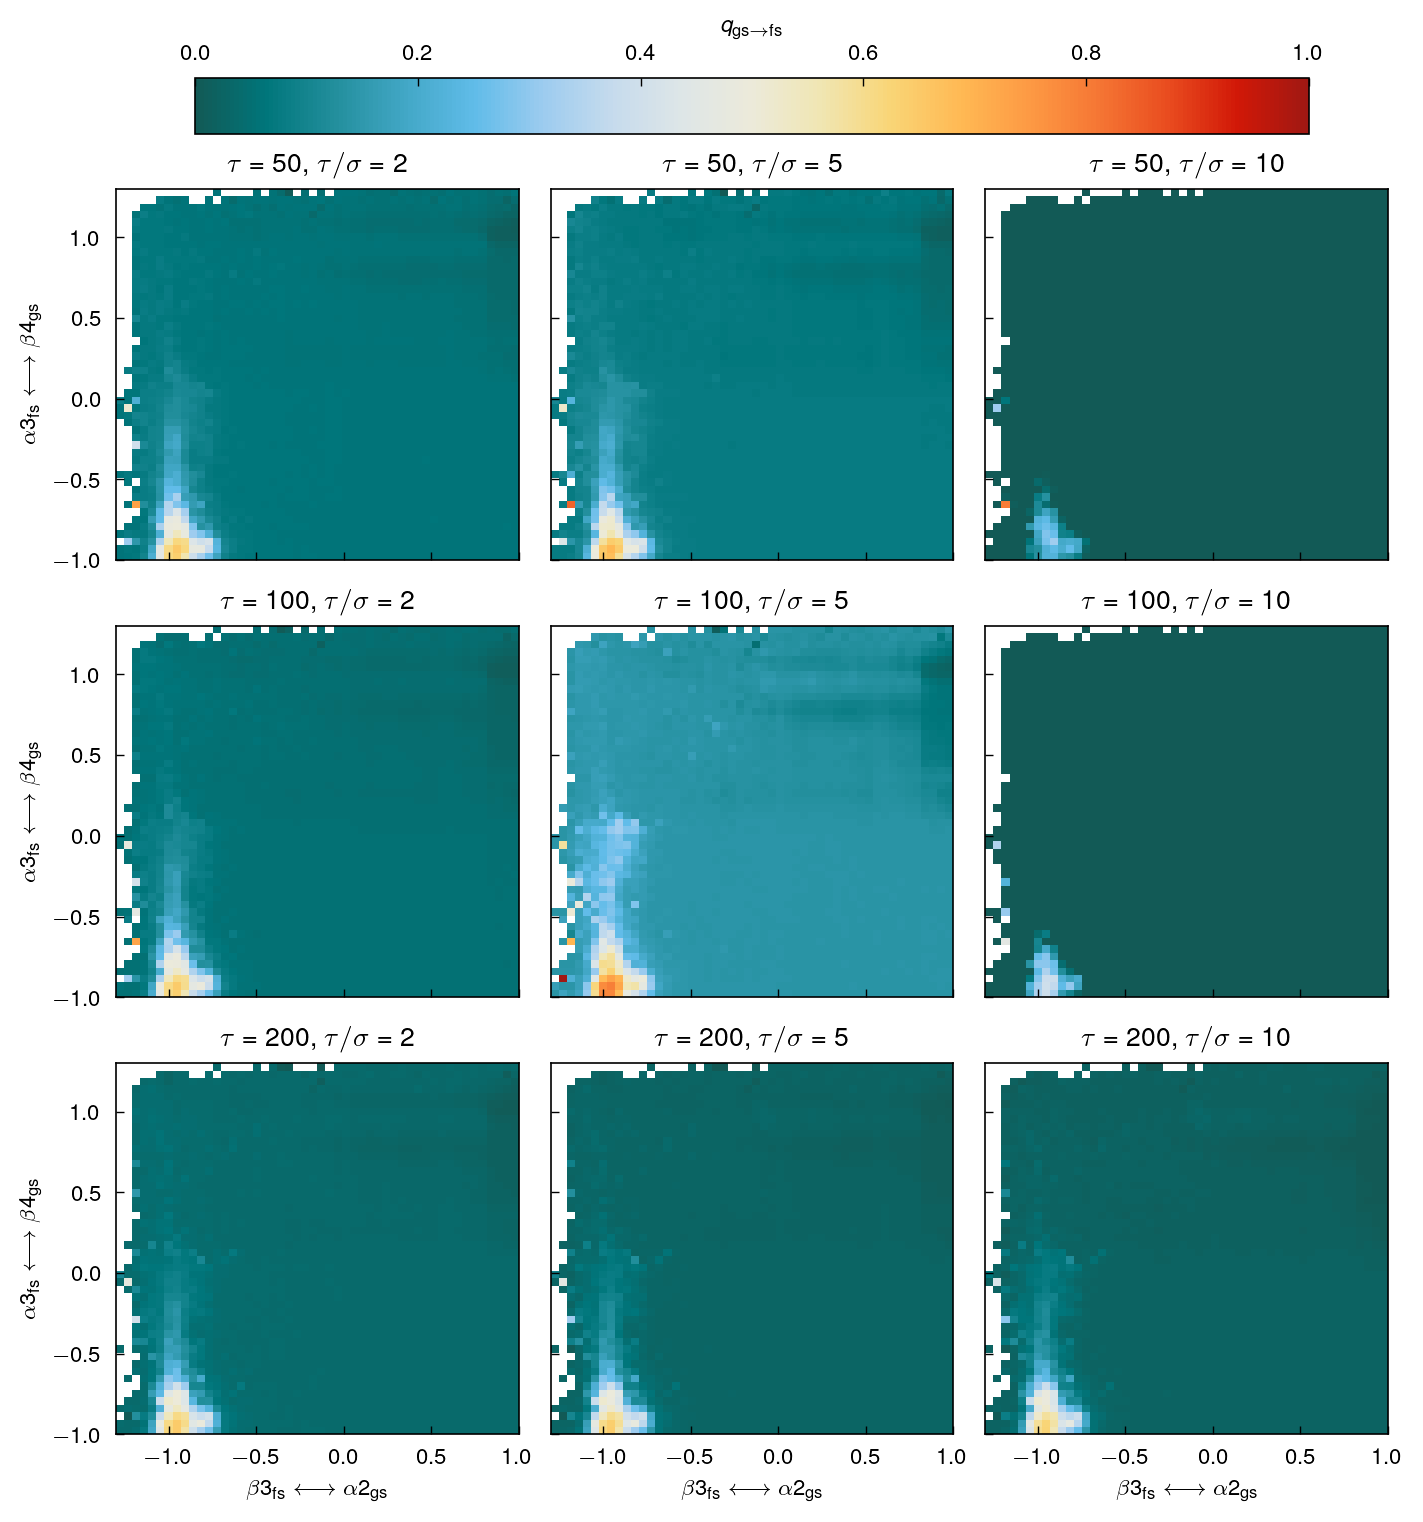

In [21]:
plot_qp(qp_all_ts[2], weights_all_ts[2], cvs_all_ts[2], cv1="orange", cv2="blue")

In [1]:
def plot_qp_ts(cv1, cv2, lag, mem):
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )
    xe = np.linspace(*lims[cv1], 51)
    ye = np.linspace(*lims[cv2], 51)
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    for ax, qp, cvs, sample_w in zip(axes, qp_all_ts, cvs_all_ts, weights_all_ts):
        q = np.asarray(qp[(lag, mem)])[..., :-lag]
        hist = extq.projection.average2d(
            cvs[cv1][..., :-lag],
            cvs[cv2][..., :-lag],
            q,
            np.broadcast_to(sample_w[..., None], q.shape),
            xe,
            ye,
        )
        pc = ax.pcolormesh(xc, yc, hist.T, cmap="nightfall", vmin=0, vmax=1)
        ax.set_xlabel(labels[cv1])
        ax.set_ylabel(labels[cv2])
        ax.label_outer()
    cb = plt.colorbar(pc, ax=axes[-1])
    cb.set_label(label=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$", rotation=-90, labelpad=10)

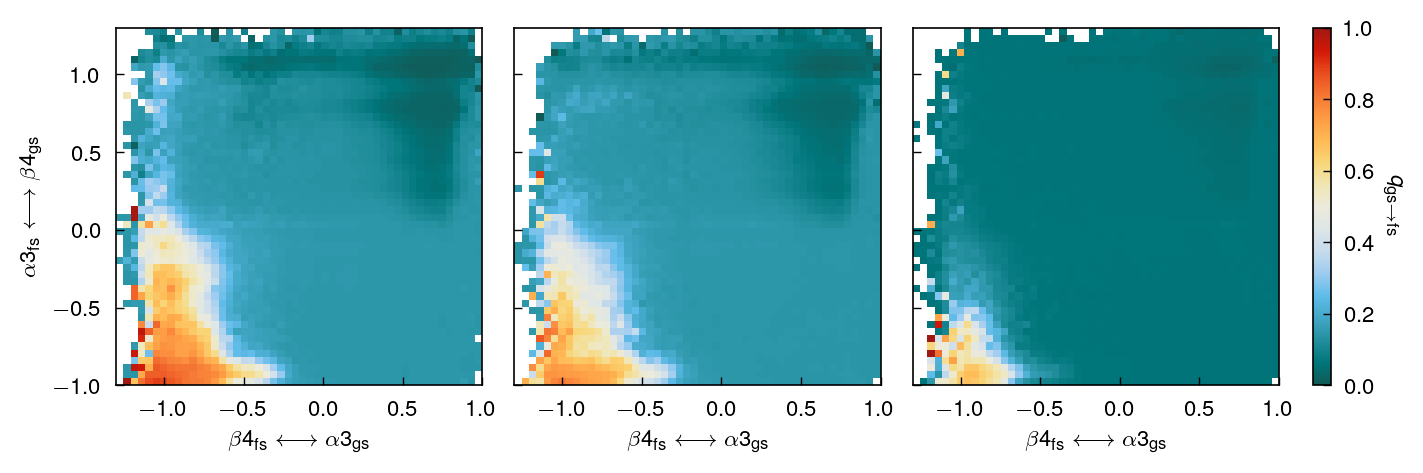

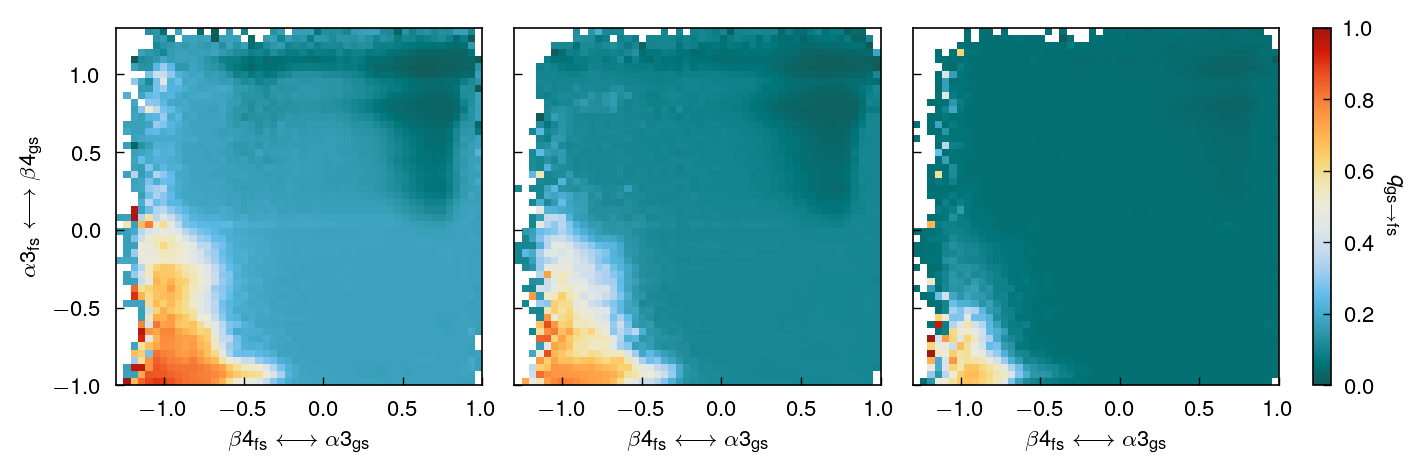

In [23]:
plot_qp_ts("green", "blue", 50, 1)
plot_qp_ts("green", "blue", 100, 1)

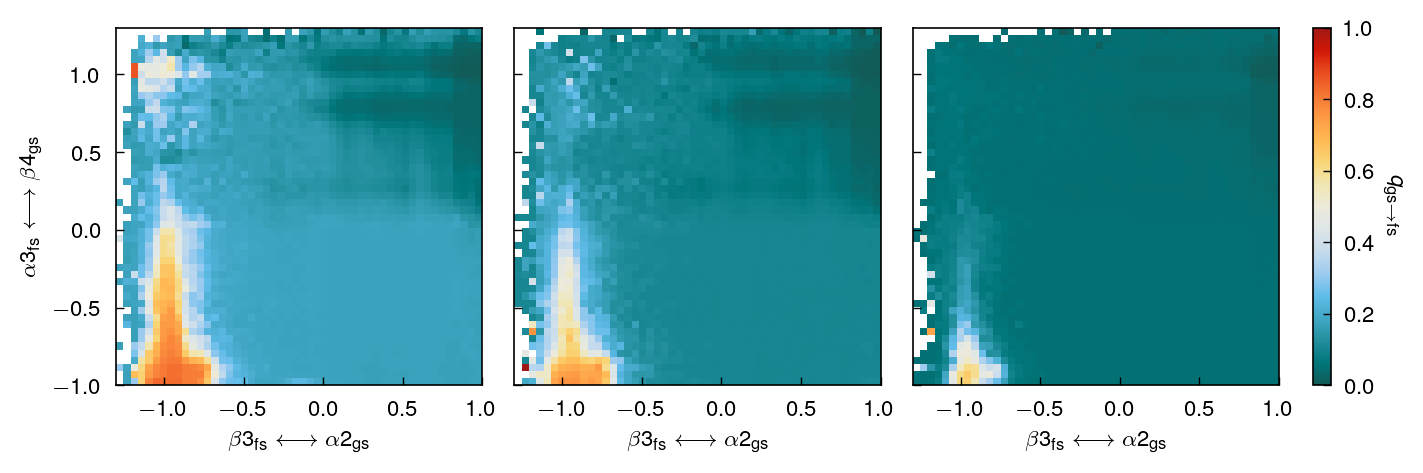

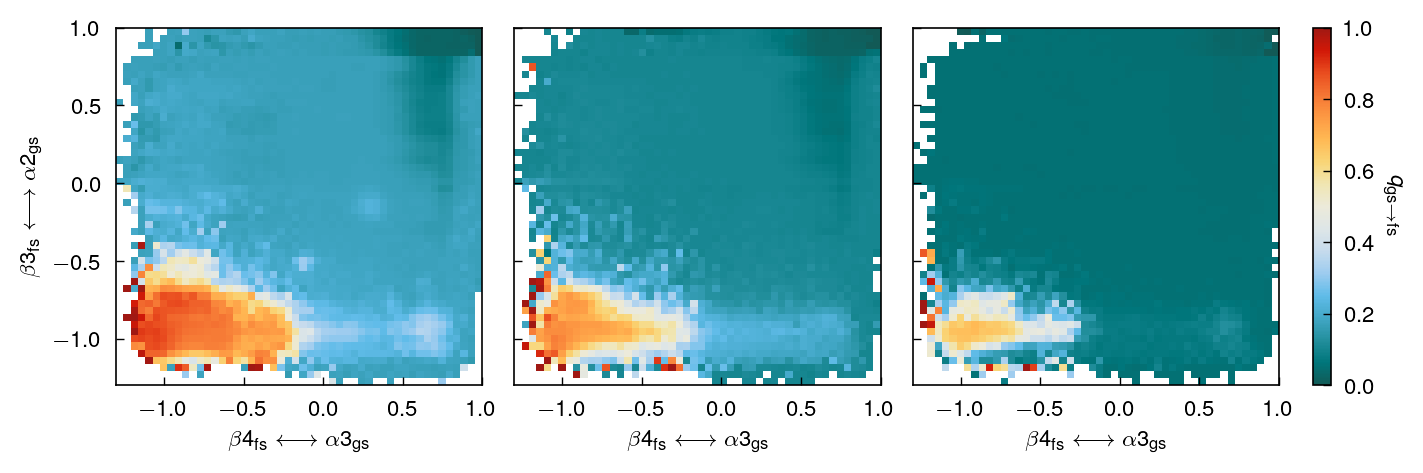

In [24]:
plot_qp_ts("orange", "blue", 100, 1)
plot_qp_ts("green", "orange", 100, 1)

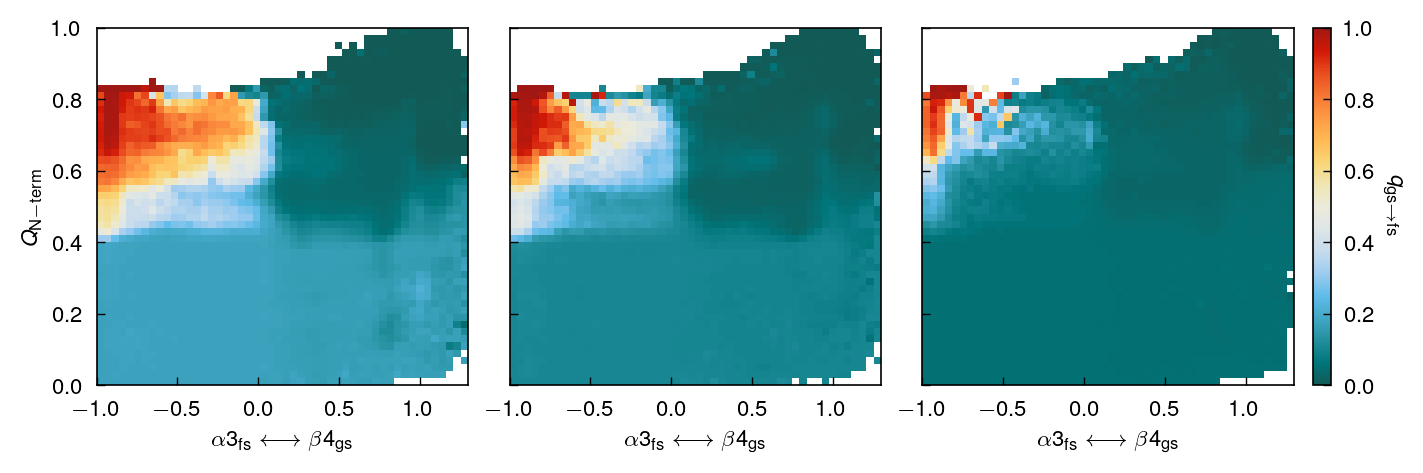

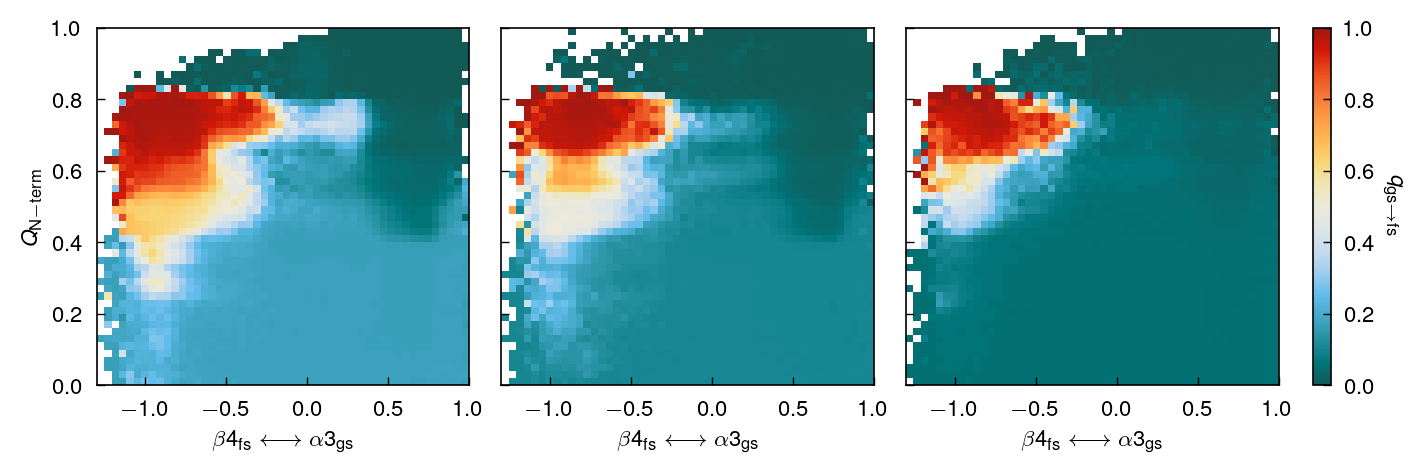

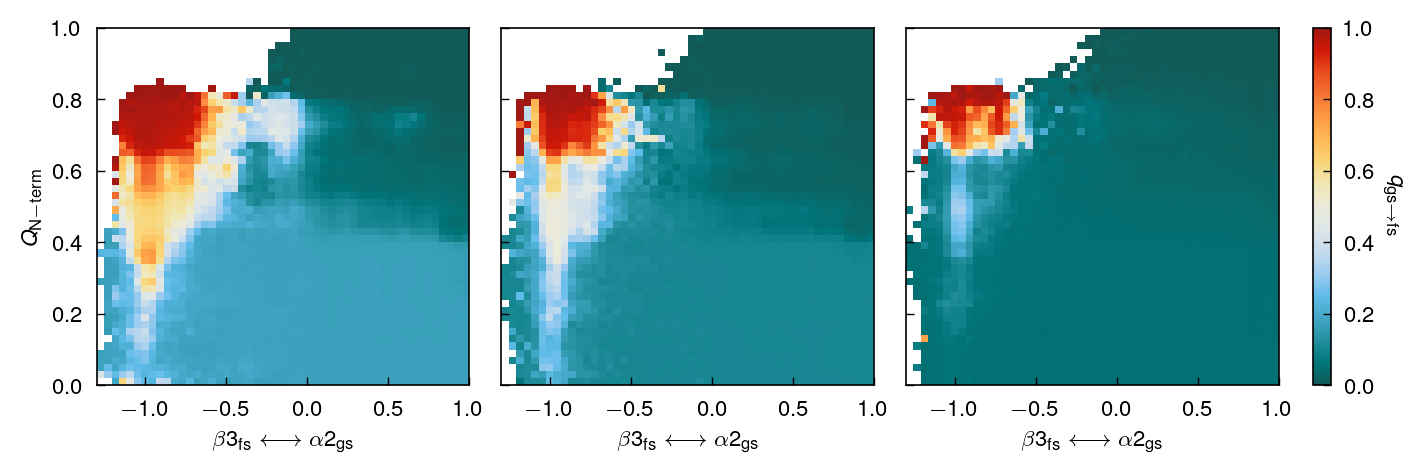

In [25]:
plot_qp_ts("blue", "q_core", 100, 1)
plot_qp_ts("green", "q_core", 100, 1)
plot_qp_ts("orange", "q_core", 100, 1)

/scratch/local/jobs/16490714/ipykernel_2148775/1374671797.py:12: RuntimeWarning: divide by zero encountered in log
  min_energy = np.min(-np.log(hist))
/scratch/local/jobs/16490714/ipykernel_2148775/1374671797.py:13: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - min_energy


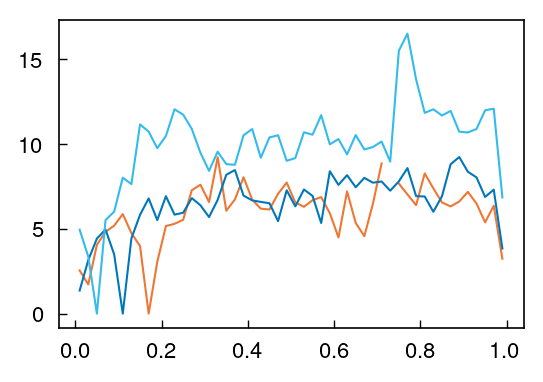

In [26]:
fig = plt.figure(figsize=(3,2), dpi=200)
qe = np.linspace(0, 1, 51)
qc = (qe[1:] + qe[:-1]) / 2
lag, mem = 100, 1
for qp, w in zip(qp_all_ts, weights_all_ts):
    q = np.asarray(qp[(lag, mem)])[..., :-lag]
    hist = extq.projection.density1d(
        q,
        np.broadcast_to(w[..., None], q.shape),
        qe,
    )
    min_energy = np.min(-np.log(hist))
    pmf = -np.log(hist) - min_energy
    plt.plot(qc, pmf)

In [27]:
def bin_inds(q, qstep=0.05, low=0, hi=1, skip=1):
    q_arr = np.concatenate(q)[::skip]
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

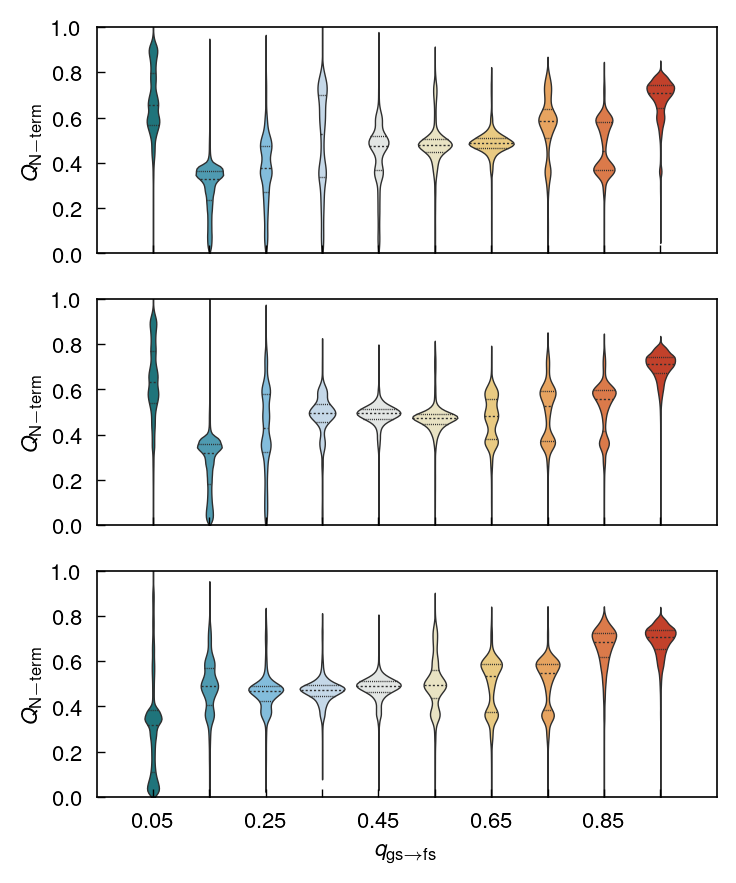

In [28]:
lag, mem = 100, 1
steps, _ = bin_inds(qp_all_ts[0][(lag, mem)], qstep=0.1, low=0, hi=1)
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.2f}")
    else:
        steplabels.append("")

f, axes = plt.subplots(3, 1, figsize=(4, 5), dpi=200, sharex=True)
for ax, qp, cvs in zip(axes, qp_all_ts, cvs_all_ts):
    _, q_inds = bin_inds(qp[(lag, mem)], qstep=0.1, low=0, hi=1, skip=10)
    q_core = cvs['q_core'].ravel()[::10]
    sns.violinplot(
        ax=ax,
        data=[q_core[inds] for inds in q_inds],
        scale="area",
        inner="quartile",
        palette="nightfall",
        orient="v",
        linewidth=0.5,
    )
    
    ax.set_xticklabels(steplabels)
    ax.set_xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    ax.set_ylabel(labels['q_core'])
    ax.label_outer()
    ax.set_ylim([0, 1])
    ax.set_xlim([-1, 10])

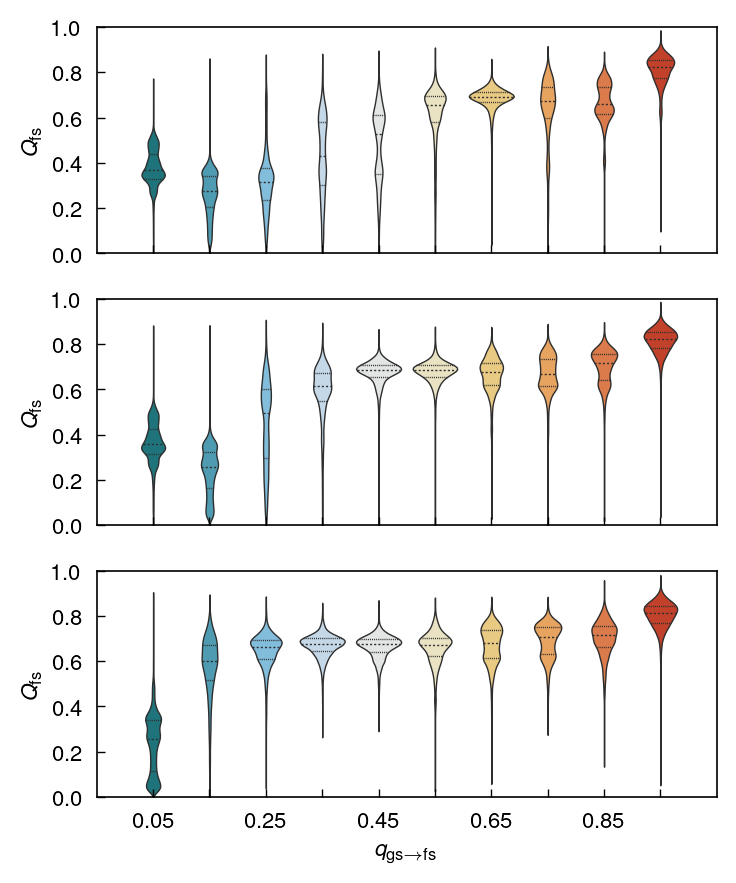

In [29]:
lag, mem = 100, 1
steps, _ = bin_inds(qp_all_ts[0][(lag, mem)], qstep=0.1, low=0, hi=1)
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.2f}")
    else:
        steplabels.append("")

f, axes = plt.subplots(3, 1, figsize=(4, 5), dpi=200, sharex=True)
for ax, qp, cvs in zip(axes, qp_all_ts, cvs_all_ts):
    _, q_inds = bin_inds(qp[(lag, mem)], qstep=0.1, low=0, hi=1, skip=10)
    q_fs = cvs['q_fs_all'].ravel()[::10]
    sns.violinplot(
        ax=ax,
        data=[q_fs[inds] for inds in q_inds],
        scale="area",
        inner="quartile",
        palette="nightfall",
        orient="v",
        linewidth=0.5,
    )
    
    ax.set_xticklabels(steplabels)
    ax.set_xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    ax.set_ylabel(labels['q_fs_all'])
    ax.label_outer()
    ax.set_ylim([0, 1])
    ax.set_xlim([-1, 10])

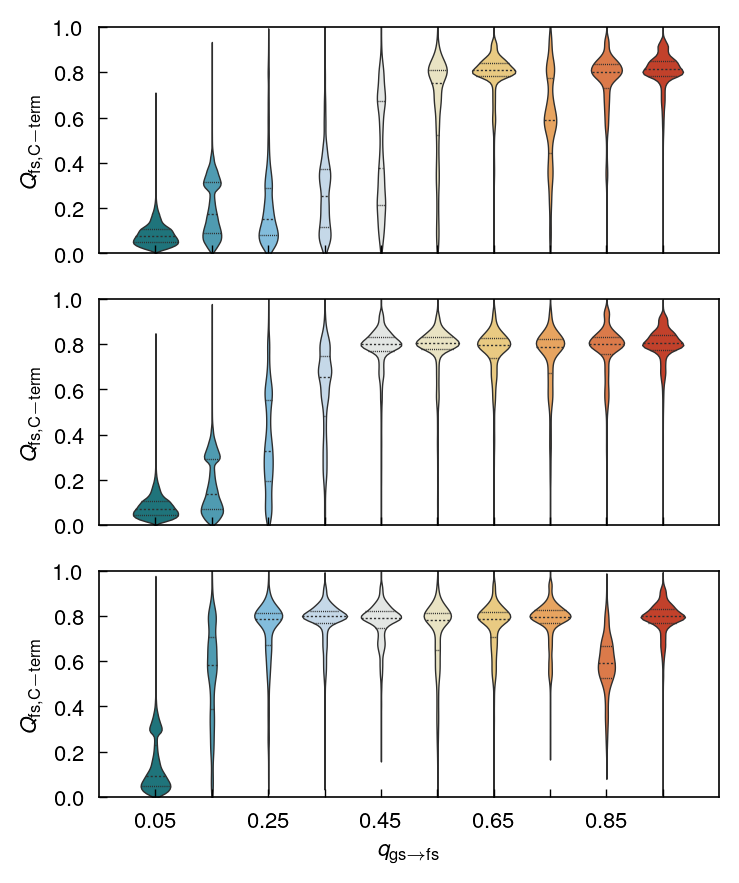

In [30]:
lag, mem = 100, 1
steps, _ = bin_inds(qp_all_ts[0][(lag, mem)], qstep=0.1, low=0, hi=1)
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.2f}")
    else:
        steplabels.append("")

f, axes = plt.subplots(3, 1, figsize=(4, 5), dpi=200, sharex=True)
for ax, qp, cvs in zip(axes, qp_all_ts, cvs_all_ts):
    _, q_inds = bin_inds(qp[(lag, mem)], qstep=0.1, low=0, hi=1, skip=10)
    q_fs = cvs['q_fs'].ravel()[::10]
    sns.violinplot(
        ax=ax,
        data=[q_fs[inds] for inds in q_inds],
        scale="area",
        inner="quartile",
        palette="nightfall",
        orient="v",
        linewidth=0.5,
    )
    
    ax.set_xticklabels(steplabels)
    ax.set_xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    ax.set_ylabel(labels['q_fs'])
    ax.label_outer()
    ax.set_ylim([0, 1])
    ax.set_xlim([-1, 10])

In [31]:
q = np.asarray(qp_all_ts[0][(lag, mem)])
steps, q_inds = bin_inds(q, qstep=0.1, low=0, hi=1)

frac_cis = np.zeros((len(steps), 4))
for k, (step, inds) in enumerate(zip(steps, q_inds)):
    n_cis_slice = np.ravel(cvs_all_ts[0]['n_cis'])[inds]
    w = np.broadcast_to(weights_all_ts[0][..., None], q.shape)
    weight_slice = np.ravel(w)[inds]
    N = np.sum(weight_slice)
    print(f"q+ = [{step:.1f}, {step+0.1:.1f}]")
    for i in range(4):
        frac = np.sum(weight_slice[n_cis_slice == i]) / N * 100
        print(f"\tFraction n cis = {i}: {frac:.1f}%")
        frac_cis[k, i] = frac

q+ = [0.0, 0.1]
	Fraction n cis = 0: 92.7%
	Fraction n cis = 1: 7.1%
	Fraction n cis = 2: 0.2%
	Fraction n cis = 3: 0.0%
q+ = [0.1, 0.2]
	Fraction n cis = 0: 86.7%
	Fraction n cis = 1: 12.7%
	Fraction n cis = 2: 0.5%
	Fraction n cis = 3: 0.0%
q+ = [0.2, 0.3]
	Fraction n cis = 0: 71.3%
	Fraction n cis = 1: 26.4%
	Fraction n cis = 2: 2.2%
	Fraction n cis = 3: 0.1%
q+ = [0.3, 0.4]
	Fraction n cis = 0: 79.4%
	Fraction n cis = 1: 19.4%
	Fraction n cis = 2: 1.2%
	Fraction n cis = 3: 0.0%
q+ = [0.4, 0.5]
	Fraction n cis = 0: 32.3%
	Fraction n cis = 1: 59.4%
	Fraction n cis = 2: 8.3%
	Fraction n cis = 3: 0.0%
q+ = [0.5, 0.6]
	Fraction n cis = 0: 35.4%
	Fraction n cis = 1: 54.8%
	Fraction n cis = 2: 9.7%
	Fraction n cis = 3: 0.1%
q+ = [0.6, 0.7]
	Fraction n cis = 0: 7.2%
	Fraction n cis = 1: 81.6%
	Fraction n cis = 2: 11.1%
	Fraction n cis = 3: 0.1%
q+ = [0.7, 0.8]
	Fraction n cis = 0: 30.3%
	Fraction n cis = 1: 59.4%
	Fraction n cis = 2: 10.3%
	Fraction n cis = 3: 0.1%
q+ = [0.8, 0.9]
	Fractio

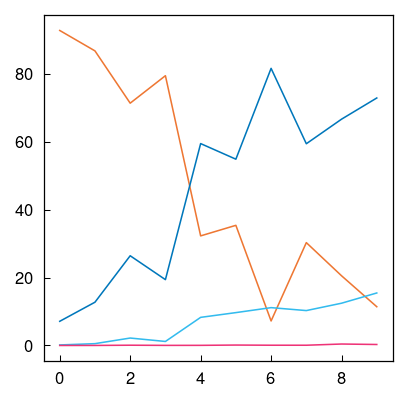

In [32]:
plt.plot(frac_cis)

In [33]:
q = np.asarray(qp_all_ts[1][(lag, mem)])
steps, q_inds = bin_inds(q, qstep=0.1, low=0, hi=1)

frac_cis = np.zeros((len(steps), 4))
for k, (step, inds) in enumerate(zip(steps, q_inds)):
    n_cis_slice = np.ravel(cvs_all_ts[1]['n_cis'])[inds]
    w = np.broadcast_to(weights_all_ts[1][..., None], q.shape)
    weight_slice = np.ravel(w)[inds]
    N = np.sum(weight_slice)
    print(f"q+ = [{step:.1f}, {step+0.1:.1f}]")
    for i in range(4):
        frac = np.sum(weight_slice[n_cis_slice == i]) / N * 100
        print(f"\tFraction n cis = {i}: {frac:.1f}%")
        frac_cis[k, i] = frac

q+ = [0.0, 0.1]
	Fraction n cis = 0: 91.2%
	Fraction n cis = 1: 8.6%
	Fraction n cis = 2: 0.3%
	Fraction n cis = 3: 0.0%
q+ = [0.1, 0.2]
	Fraction n cis = 0: 84.7%
	Fraction n cis = 1: 14.6%
	Fraction n cis = 2: 0.7%
	Fraction n cis = 3: 0.0%
q+ = [0.2, 0.3]
	Fraction n cis = 0: 44.6%
	Fraction n cis = 1: 51.0%
	Fraction n cis = 2: 4.4%
	Fraction n cis = 3: 0.0%
q+ = [0.3, 0.4]
	Fraction n cis = 0: 43.2%
	Fraction n cis = 1: 49.5%
	Fraction n cis = 2: 7.2%
	Fraction n cis = 3: 0.1%
q+ = [0.4, 0.5]
	Fraction n cis = 0: 17.1%
	Fraction n cis = 1: 73.8%
	Fraction n cis = 2: 9.0%
	Fraction n cis = 3: 0.1%
q+ = [0.5, 0.6]
	Fraction n cis = 0: 11.2%
	Fraction n cis = 1: 75.8%
	Fraction n cis = 2: 12.9%
	Fraction n cis = 3: 0.2%
q+ = [0.6, 0.7]
	Fraction n cis = 0: 16.3%
	Fraction n cis = 1: 71.0%
	Fraction n cis = 2: 12.4%
	Fraction n cis = 3: 0.2%
q+ = [0.7, 0.8]
	Fraction n cis = 0: 21.4%
	Fraction n cis = 1: 63.6%
	Fraction n cis = 2: 14.8%
	Fraction n cis = 3: 0.3%
q+ = [0.8, 0.9]
	Fract

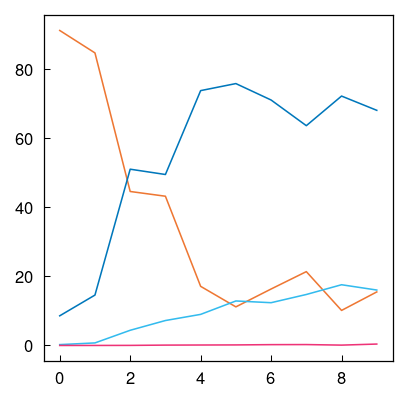

In [34]:
plt.plot(frac_cis)

In [35]:
q = np.asarray(qp_all_ts[2][(lag, mem)])
steps, q_inds = bin_inds(q, qstep=0.1, low=0, hi=1)

frac_cis = np.zeros((len(steps), 4))
for k, (step, inds) in enumerate(zip(steps, q_inds)):
    n_cis_slice = np.ravel(cvs_all_ts[2]['n_cis'])[inds]
    w = np.broadcast_to(weights_all_ts[2][..., None], q.shape)
    weight_slice = np.ravel(w)[inds]
    N = np.sum(weight_slice)
    print(f"q+ = [{step:.1f}, {step+0.1:.1f}]")
    for i in range(4):
        frac = np.sum(weight_slice[n_cis_slice == i]) / N * 100
        print(f"\tFraction n cis = {i}: {frac:.1f}%")
        frac_cis[k, i] = frac

q+ = [0.0, 0.1]
	Fraction n cis = 0: 85.8%
	Fraction n cis = 1: 13.6%
	Fraction n cis = 2: 0.6%
	Fraction n cis = 3: 0.0%
q+ = [0.1, 0.2]
	Fraction n cis = 0: 52.9%
	Fraction n cis = 1: 43.8%
	Fraction n cis = 2: 3.2%
	Fraction n cis = 3: 0.1%
q+ = [0.2, 0.3]
	Fraction n cis = 0: 22.4%
	Fraction n cis = 1: 69.6%
	Fraction n cis = 2: 7.9%
	Fraction n cis = 3: 0.1%
q+ = [0.3, 0.4]
	Fraction n cis = 0: 9.2%
	Fraction n cis = 1: 80.8%
	Fraction n cis = 2: 9.9%
	Fraction n cis = 3: 0.1%
q+ = [0.4, 0.5]
	Fraction n cis = 0: 11.4%
	Fraction n cis = 1: 76.9%
	Fraction n cis = 2: 11.6%
	Fraction n cis = 3: 0.1%
q+ = [0.5, 0.6]
	Fraction n cis = 0: 22.7%
	Fraction n cis = 1: 64.8%
	Fraction n cis = 2: 12.0%
	Fraction n cis = 3: 0.5%
q+ = [0.6, 0.7]
	Fraction n cis = 0: 17.5%
	Fraction n cis = 1: 66.8%
	Fraction n cis = 2: 15.6%
	Fraction n cis = 3: 0.2%
q+ = [0.7, 0.8]
	Fraction n cis = 0: 7.3%
	Fraction n cis = 1: 79.4%
	Fraction n cis = 2: 13.2%
	Fraction n cis = 3: 0.1%
q+ = [0.8, 0.9]
	Fract

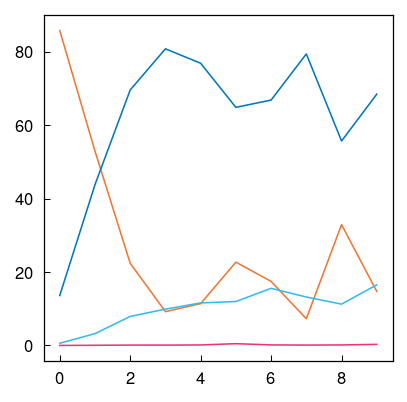

In [36]:
plt.plot(frac_cis)

In [37]:
def plot_pmf_ts(cv1, cv2):
    clines = np.arange(0, 13, 2)
    fig, axes = plt.subplots(
        nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
    )
    xe = np.linspace(*lims[cv1], 51)
    ye = np.linspace(*lims[cv2], 51)
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
        cv1_delay = cvs[cv1]
        cv2_delay = cvs[cv2]
        hist = extq.projection.density2d(
            cv1_delay,
            cv2_delay,
            np.broadcast_to(sample_w[..., None], cv1_delay.shape),
            xe,
            ye,
        )
        pmf = -np.log(hist) - np.min(-np.log(hist))
        pc = ax.pcolormesh(xc, yc, pmf.T, cmap="flare_r", vmin=0, vmax=12)
        ax.contour(xc, yc, pmf.T, colors="white", levels=clines, linewidths=0.5)
        ax.set_xlabel(labels[cv1])
        ax.set_ylabel(labels[cv2])
        ax.label_outer()
    cb = plt.colorbar(pc, ax=axes[-1], extend='max')
    cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)

/scratch/local/jobs/16490714/ipykernel_2148775/2810408379.py:20: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


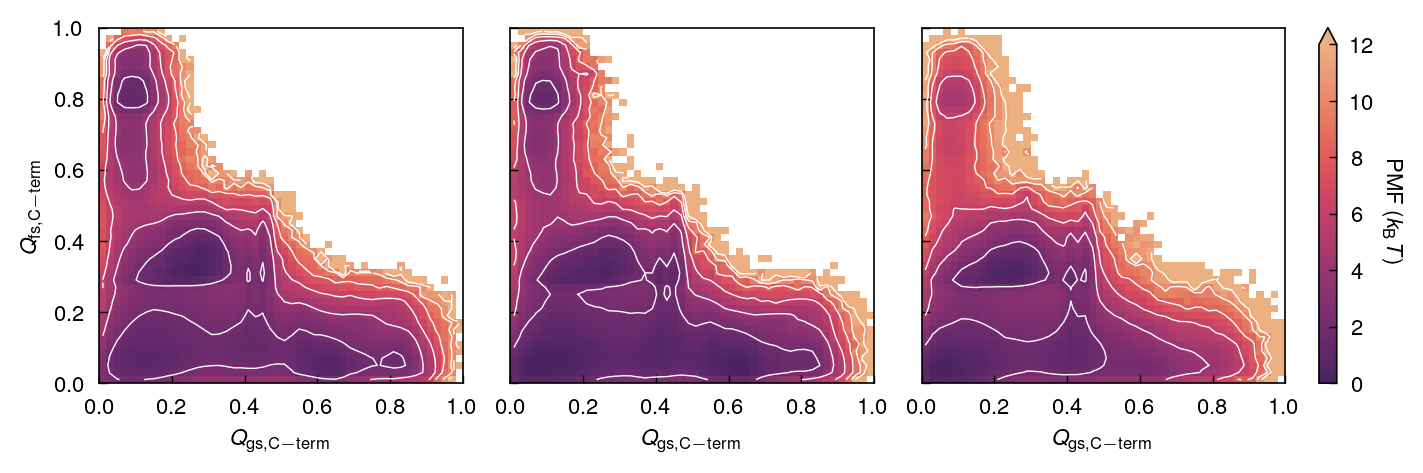

In [38]:
plot_pmf_ts("q_gs", "q_fs")

/project/dinner/scguo/extq/src/extq/projection.py:145: RuntimeWarning: invalid value encountered in divide
  return numer / denom


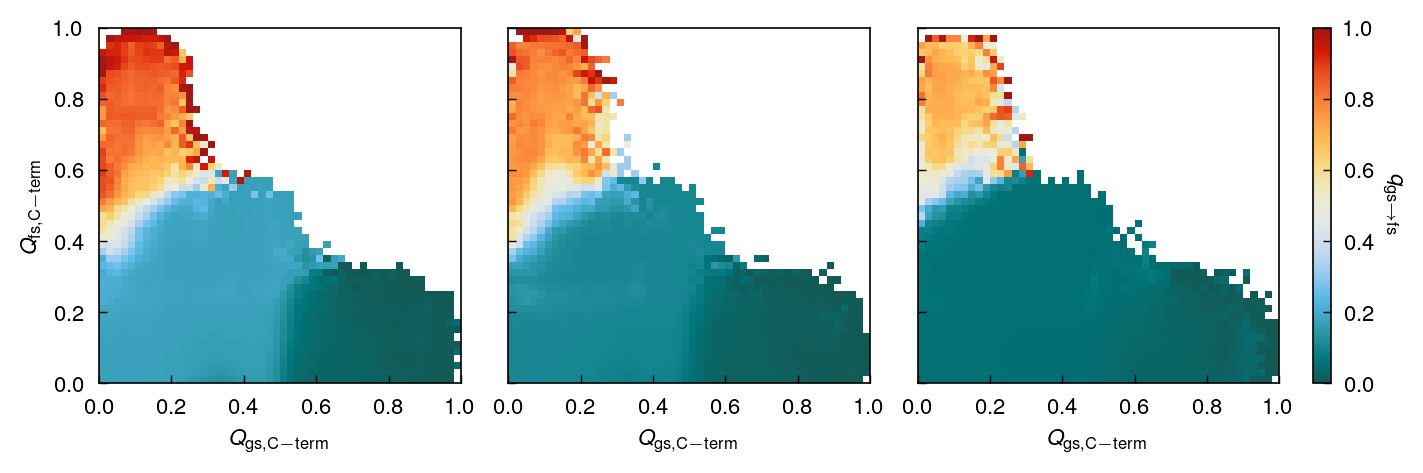

In [39]:
plot_qp_ts("q_gs", "q_fs", 100, 1)

In [53]:
def kdesum1d(
    x,
    w,
    *,
    xmin=None,
    xmax=None,
    xstd=None,
    nx=100,
    cut=4.0,
):
    """Compute a 2D kernel density estimate.

    This function histograms the data, then uses a Gaussian filter to
    approximate a kernel density estimate with a Gaussian kernel.

    Parameters
    ----------
    x : ndarray or list/tuple of ndarray
        Coordinates of each frame.
    w : ndarray or list/tuple of ndarray
        Weight or value of each frame. The output is the sum of these
        values in each bin, after smoothing.
    xmin, xmax : float, optional
        Limits of kernel density estimate. If None, takes the min/max
        of the data along the coordinate.
    xstd : float, optional
        Standard deviation of the Gaussian filter. If None, these are
        set to (xmax - xmin) / nx. Increase this to smooth the results more.
    nx : int, optional
        Number of bins in each dimension. This should be set as high as
        reasonable, since xstd takes care of the smoothing.
    cut : float, optional
        Number of standard deviations at which to truncate the Gaussian
        filter. The default, 4, usually doesn't need to be changed.

    Returns
    -------
    kde : (nx,) ndarray
        Kernel density estimate, given as bins.
    xedges : (nx+1,) ndarray
        Bin edges along the x dimension.

    """

    # flatten input to 1D arrays
    x = _flatten(x)
    w = _flatten(w)

    # limits
    _xmin = np.min(x)
    _xmax = np.max(x)
    if xmin is None:
        xmin = _xmin
    if xmax is None:
        xmax = _xmax

    # separation between grid points
    xsep = (xmax - xmin) / nx

    # number of grid points to pad the boundaries,
    # since the Gaussian filter extends beyond the boundaries
    # usually overestimates the padding, but whatever
    ax = max(0, int(np.ceil((xmin - _xmin) / xsep + 1e-6)))
    bx = max(0, int(np.ceil((_xmax - xmax) / xsep + 1e-6)))

    # output bin edges
    xedges = np.linspace(xmin, xmax, nx + 1)

    # bin edges, with the added padding
    xedges_padded = np.concatenate(
        [
            xmin + xsep * np.arange(-ax, 0),
            xedges,
            xmax + xsep * np.arange(1, bx + 1),
        ]
    )
    assert np.allclose(xedges_padded[1:] - xedges_padded[:-1], xsep)
    assert xedges_padded[0] <= _xmin and _xmax <= xedges_padded[-1]

    # construct 2D histogram on padded edges
    hist_padded, _ = np.histogram(x, weights=w, bins=xedges_padded)
    # Gaussian kernel parameters
    if xstd is None:
        xstd = xsep

    # apply Gaussian filter to histogram
    kde_padded = scipy.ndimage.gaussian_filter(
        hist_padded,
        sigma=(xstd / xsep),  # in units of grid points
        mode="constant",
        truncate=cut,
    )

    # remove the padding
    assert ax + nx + bx == kde_padded.shape[0]
    kde = kde_padded[ax : ax + nx]
    return kde, xedges


def _flatten(a):
    if isinstance(a, np.ndarray):
        # avoid creating a new array (and using twice the memory)
        return np.ravel(a)
    else:
        return np.ravel(np.concatenate(a))

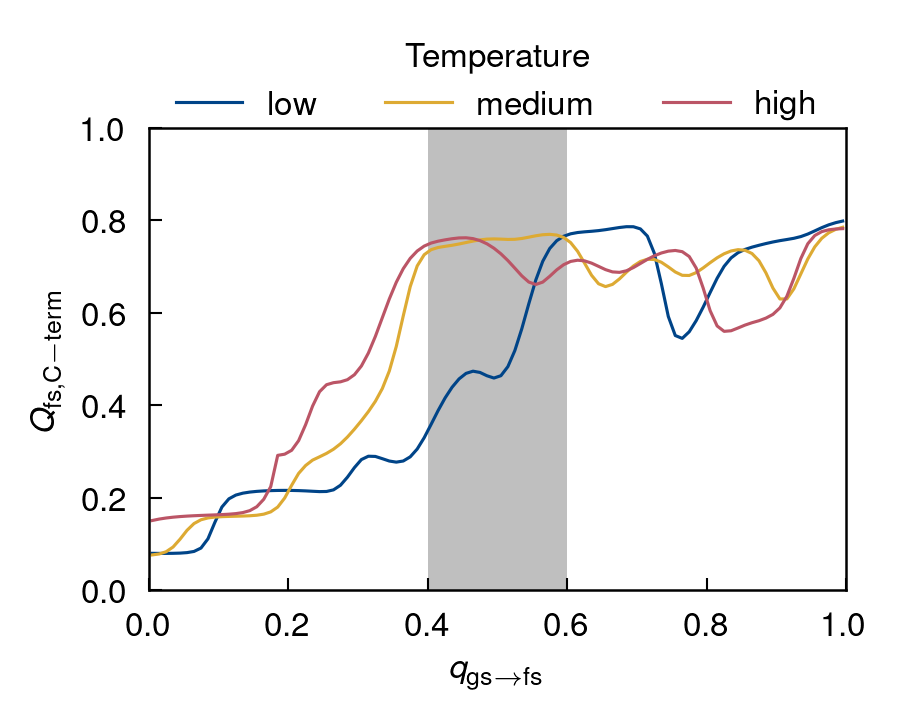

In [63]:
with mpl.style.context('high-contrast'):
    fig = plt.figure(figsize=(3,2), dpi=300)
    cv1 = 'q_fs'
    
    lag, mem = 100, 1
    xstd = 0.03

    for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
        q = np.asarray(qp[(lag, mem)])[..., :-lag]
        w = np.broadcast_to(w[..., None], q.shape)
        numer, xe = kdesum1d(q, cvs[cv1][..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
        denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
        xc = (xe[1:] + xe[:-1]) / 2
        plt.plot(xc, numer / denom)
    plt.axvspan(0.4, 0.6, ec=None, color='gray', alpha=0.5)
    plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    plt.ylabel(labels[cv1])
    plt.xlim([0, 1])
    plt.ylim(lims[cv1])
    plt.legend(["low", "medium", "high"], title='Temperature', bbox_to_anchor=(0.5, 1.1), loc='center', ncols=3)
    plt.savefig("../../dga/figures/qp_qfs_ts.pdf", bbox_inches='tight')

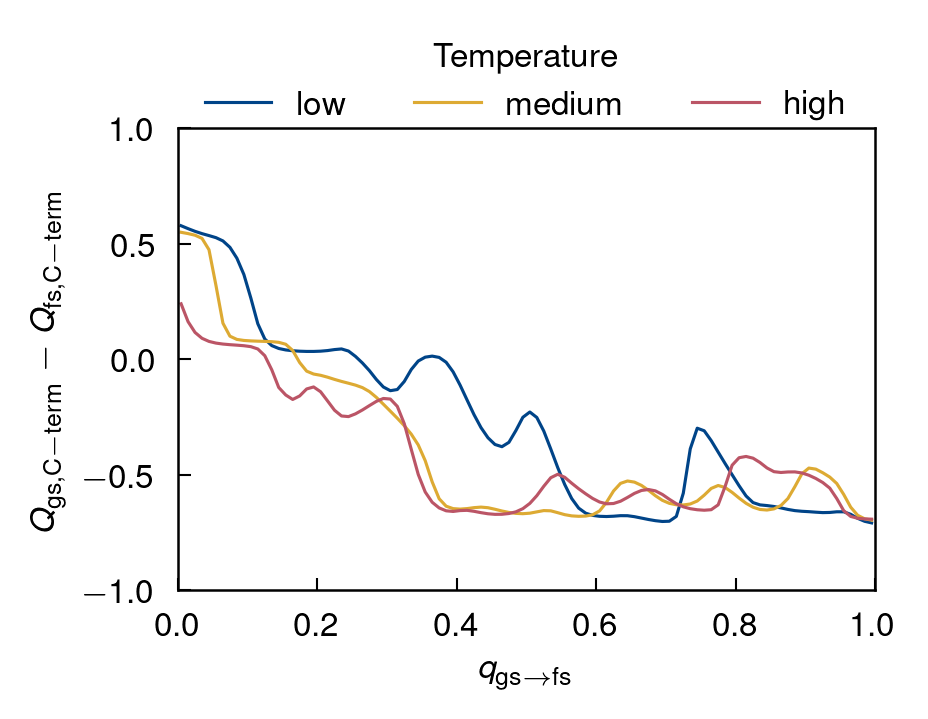

In [61]:
with mpl.style.context('high-contrast'):
    fig = plt.figure(figsize=(3,2), dpi=300)
    
    lag, mem = 100, 1
    xstd = 0.02
    for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
        cv1_delay = cvs['q_gs'] - cvs['q_fs']
        q = np.asarray(qp[(lag, mem)])[..., :-lag]
        w = np.broadcast_to(w[..., None], q.shape)
        numer, xe = kdesum1d(q, cv1_delay[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
        denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
        xc = (xe[1:] + xe[:-1]) / 2
        plt.plot(xc, numer / denom)
    plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    plt.ylabel(f"{labels['q_gs']} $-$ {labels['q_fs']}")
    plt.xlim([0, 1])
    plt.ylim([-1, 1])
    plt.legend(["low", "medium", "high"], title='Temperature', bbox_to_anchor=(0.5, 1.1), loc='center', ncols=3)

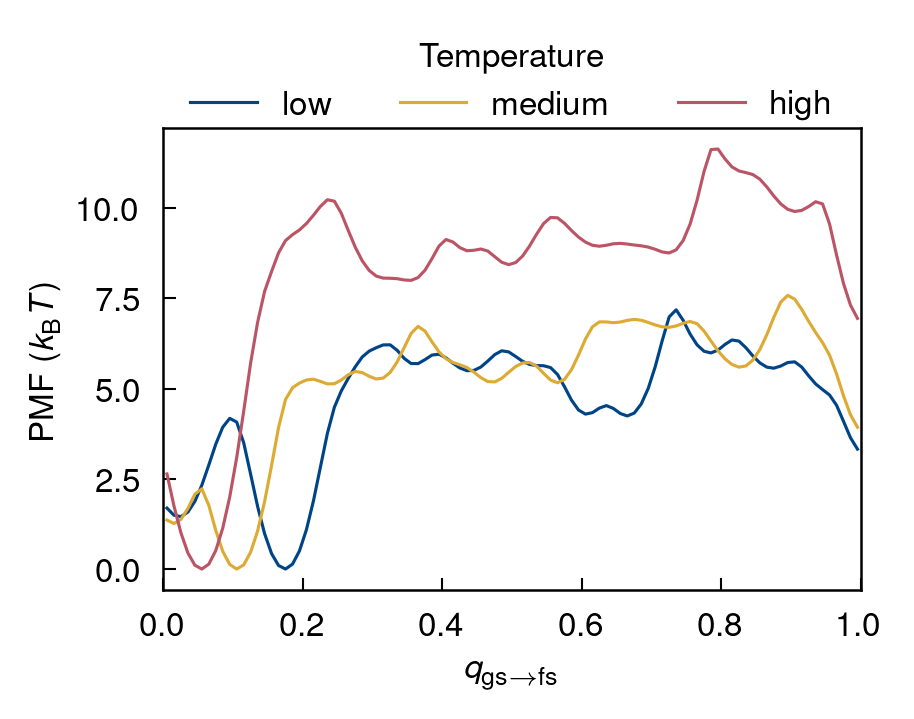

In [73]:
with mpl.style.context('high-contrast'):
    fig = plt.figure(figsize=(3,2), dpi=300)
    
    lag, mem = 100, 1
    xstd = 0.02
    for qp, w, cvs in zip(qp_all_ts, weights_all_ts, cvs_all_ts):
        q = np.asarray(qp[(lag, mem)])[..., :-lag]
        w = np.broadcast_to(w[..., None], q.shape)
        hist, xe = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
        xc = (xe[1:] + xe[:-1]) / 2
        min_energy = np.min(-np.log(hist))
        pmf = -np.log(hist) - min_energy
        plt.plot(xc, pmf)
    plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
    plt.ylabel(r"PMF ($k_{\mathrm{B}}T$)")
    plt.xlim([0, 1])
    # plt.ylim([-1, 1])
    plt.legend(["low", "medium", "high"], title='Temperature', bbox_to_anchor=(0.5, 1.1), loc='center', ncols=3)
    plt.savefig("../../dga/figures/pmf_qp_ts.pdf", bbox_inches='tight')

/scratch/local/jobs/16490714/ipykernel_2148775/3973879261.py:21: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


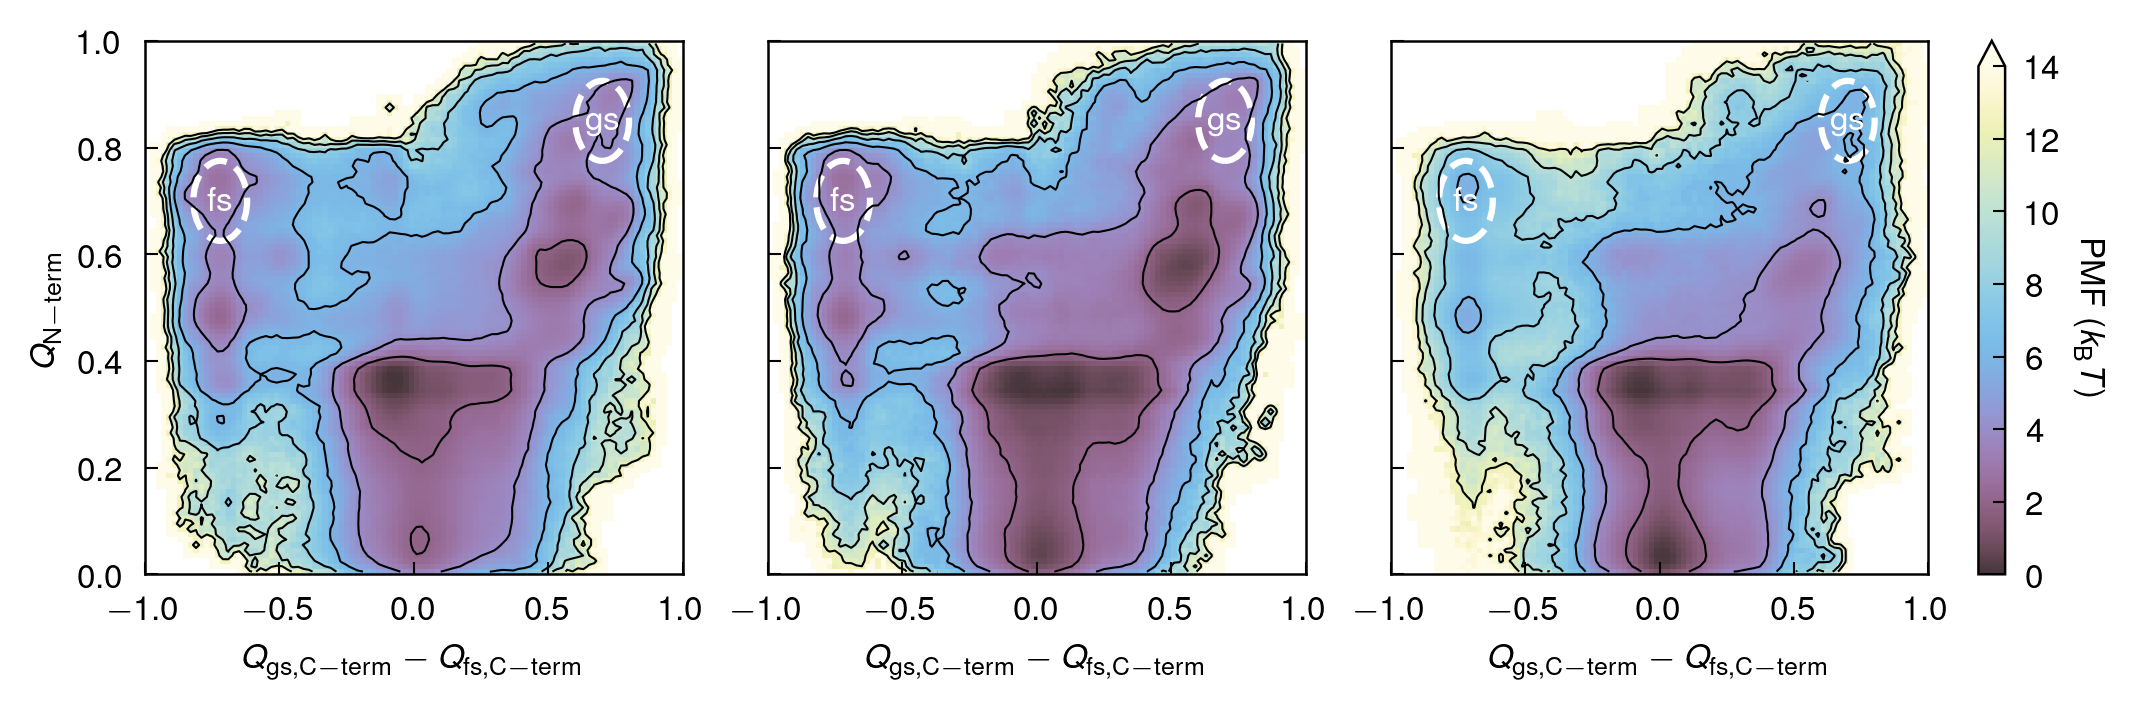

In [78]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv2 = "q_core"
xe = np.linspace(-1, 1, 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs['q_gs'] - cvs['q_fs']
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode='constant')
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(r"$Q_{\mathrm{gs,C-term}}-Q_{\mathrm{fs,C-term}}$")
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend='max')
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)


for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.7, 0.85), width=0.2, height=0.15)
    ellipseB = mpl.patches.Ellipse(xy=(-0.72, 0.7), width=0.2, height=0.15)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.7, 0.85, "gs", ax=ax, color='white')
    pplt.text(-0.72, 0.7, "fs", ax=ax, color='white')
plt.savefig("../../dga/figures/pmfs_qdiff_qcore_ts.pdf", bbox_inches='tight', dpi=400)

/scratch/local/jobs/16490714/ipykernel_2148775/1383250974.py:21: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(hist) - np.min(-np.log(hist))


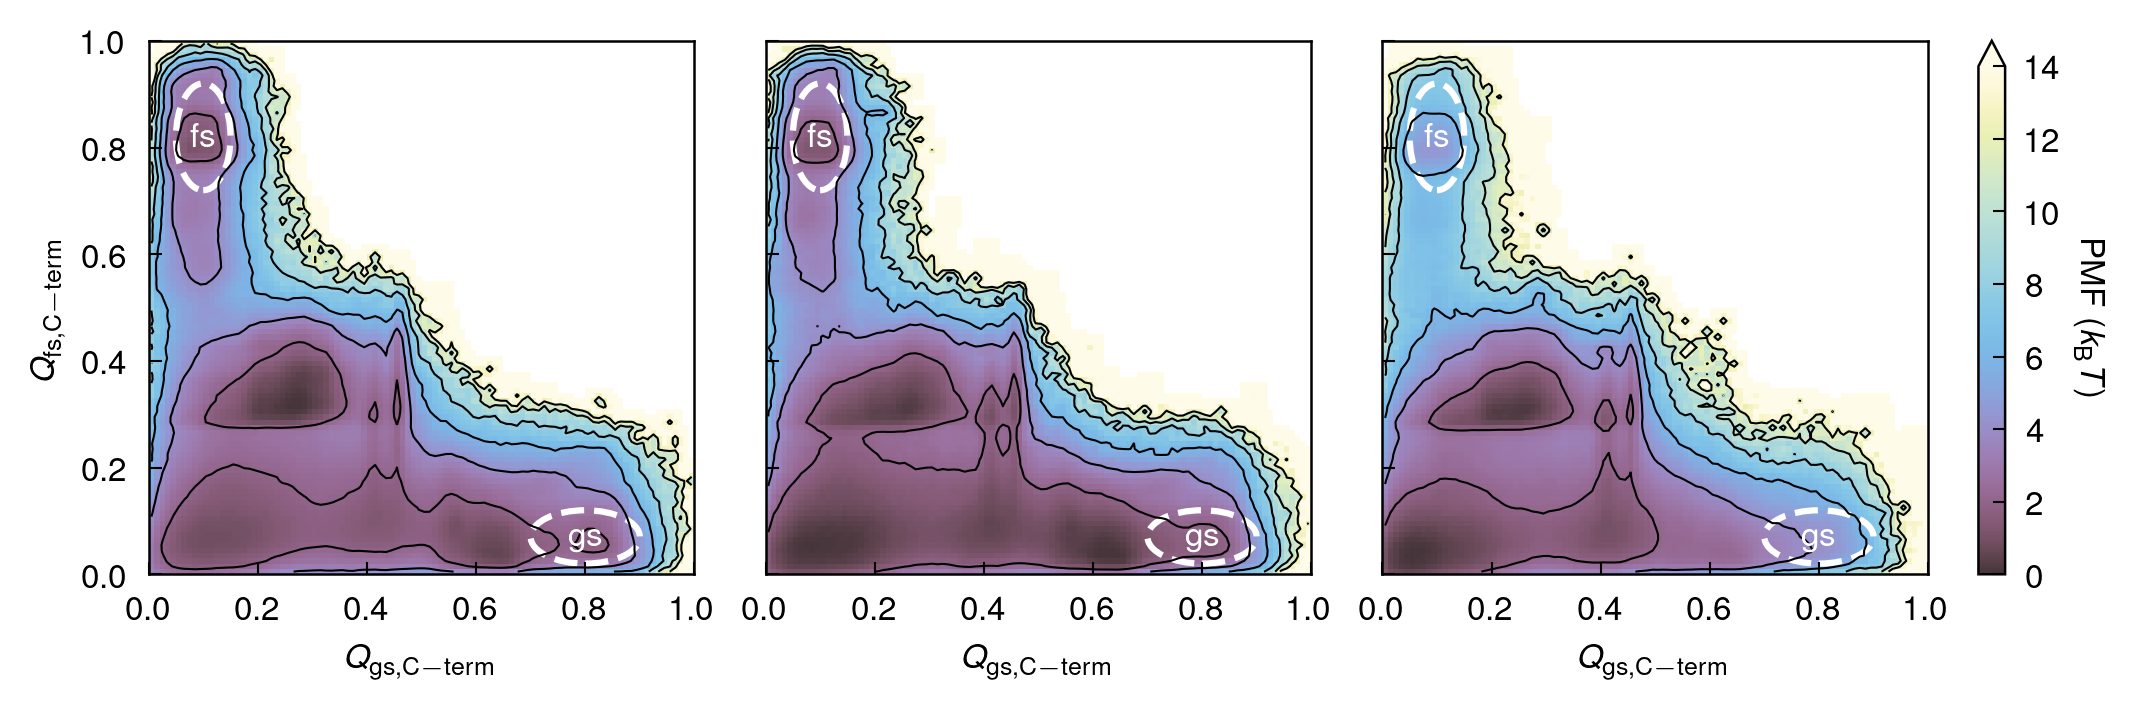

In [79]:
clines = np.arange(0, 14, 2)
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=300, sharex=True, sharey=True, constrained_layout=True
)
cv1, cv2 = "q_gs", "q_fs"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    hist = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    hist = scipy.ndimage.gaussian_filter(hist, sigma=0.5, mode='constant')
    pmf = -np.log(hist) - np.min(-np.log(hist))
    pc = ax.pcolormesh(xc, yc, pmf.T, cmap="iridescent_r", vmin=0, vmax=14, rasterized=True)
    ax.contour(xc, yc, pmf.T, colors="black", levels=clines, linewidths=0.5)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend='max')
cb.set_label(label=r"PMF ($k_{\mathrm{B}}T$)", rotation=-90, labelpad=10)


for ax in axes:
    ellipseA = mpl.patches.Ellipse(xy=(0.8, 0.07), width=0.2, height=0.1)
    ellipseB = mpl.patches.Ellipse(xy=(0.1, 0.82), width=0.1, height=0.2)
    for e in (ellipseA, ellipseB):
        e.set_fill(False)
        e.set_linestyle("--")
        e.set_linewidth(1.5)
        e.set_edgecolor("white")
    ax.add_artist(ellipseA)
    ax.add_artist(ellipseB)
    pplt.text(0.8, 0.07, "gs", ax=ax, color='white')
    pplt.text(0.1, 0.82, "fs", ax=ax, color='white')
plt.savefig("../../dga/figures/pmfs_qgs_qfs_ts.pdf", bbox_inches='tight', dpi=400)